In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale
import talib

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

In [201]:
data = pd.read_hdf('data/data_alpha_factor.h5', 'data/top500')
price_sample = pd.read_hdf('data/data_alpha_factor.h5', 'data/sample')

In [202]:
data.sample(10).sort_values(by='date')

open        high         low       close      volume  \
ticker date                                                                     
MSFT   2007-12-17   27.310146   27.388109   26.787800   26.811189  58121200.0   
WAT    2008-01-04   77.590000   78.650000   76.930000   77.510000   1044200.0   
JWN    2009-09-15   23.136125   24.124449   22.653636   23.688652   7018100.0   
AVB    2011-06-29  105.832992  106.122379  105.113658  105.708969    920100.0   
PAY    2011-11-15   44.090000   44.900000   43.200000   44.170000   2201700.0   
ROK    2011-11-21   61.162483   61.303026   59.669216   60.494905   1013100.0   
CLF    2013-06-11   16.642534   16.926884   16.452334   16.642534   6695200.0   
TSN    2014-02-06   34.327353   34.635480   34.067370   34.375497   3298900.0   
NRG    2015-11-13   12.202273   12.503924   11.997928   12.270387   8722080.0   
GPC    2016-01-15   73.182960   74.848588   72.811762   74.686784   1357895.0   

                      marketcap  sector    ret_01    ret_02    ret_03  \
ticker date                                                             
MSFT   2007-12-17  7.610200e+11     2.0 -0.026055 -0.023566 -0.002321   
WAT    2008-01-04  1.509000e+10     4.0 -0.003599  0.009902 -0.019729   
JWN    2009-09-15  8.600000e+09     1.0  0.023193  0.037845  0.016700   
AVB    2011-06-29  2.363000e+10     1.0  0.003926  0.009298  0.009773   
PAY    2011-11-15  2.530000e+09     9.0 -0.006076  0.082863  0.086860   
ROK    2011-11-21  2.099000e+10     4.0 -0.033404 -0.022982 -0.046650   
CLF    2013-06-11  2.440000e+09     5.0 -0.018508 -0.024526 -0.056604   
TSN    2014-02-06  2.457000e+10    11.0  0.003091  0.006484 -0.008884   
NRG    2015-11-13  9.630000e+09     3.0  0.007994 -0.032233 -0.071429   
GPC    2016-01-15  1.331000e+10     4.0 -0.000382  0.013824 -0.014691   

                     ret_04    ret_05    ret_10    ret_21    ret_42    ret_63  \
ticker date                                                                     
MSFT   2007-12-17  0.008504 -0.010644  0.044654  0.018661  0.110031  0.192526   
WAT    2008-01-04 -0.024172 -0.018239  0.010429 -0.030762  0.029623  0.159461   
JWN    2009-09-15  0.023193  0.043180  0.085592  0.098356  0.404828  0.611964   
AVB    2011-06-29  0.008902 -0.020868 -0.011926 -0.032494  0.016871  0.089222   
PAY    2011-11-15  0.061269  0.000680  0.112875  0.151760  0.138109  0.213462   
ROK    2011-11-21 -0.073955 -0.064139 -0.007504  0.041270  0.344317  0.208971   
CLF    2013-06-11 -0.040044 -0.088067 -0.128486 -0.250956 -0.115211 -0.262244   
TSN    2014-02-06 -0.045455  0.035083  0.006768  0.071750  0.084777  0.284901   
NRG    2015-11-13 -0.051880 -0.066617 -0.021722 -0.170881 -0.327789 -0.399630   
GPC    2016-01-15 -0.007588 -0.001146 -0.086390 -0.088618 -0.079409 -0.056207   

                    ret_126   ret_252   ret_fwd  
ticker date                                      
MSFT   2007-12-17  0.136632       NaN  0.010177  
WAT    2008-01-04  0.270656  0.574766  0.009934  
JWN    2009-09-15  0.963447 -0.019487  0.033180  
AVB    2011-06-29  0.148965  0.412283  0.004302  
PAY    2011-11-15 -0.027307  0.387249 -0.002490  
ROK    2011-11-21 -0.138332  0.050543  0.004646  
CLF    2013-06-11 -0.399462 -0.623820 -0.007429  
TSN    2014-02-06  0.171483  0.539022  0.010924  
NRG    2015-11-13 -0.507311 -0.588473  0.008723  
GPC    2016-01-15 -0.121696 -0.151524 -0.002039

In [203]:
price_sample.sample(5).sort_values(by='date')

open        high         low       close       volume  \
date                                                                      
2007-05-16   13.947618   13.986172   13.290911   13.794686  281691900.0   
2009-11-09   25.309535   25.946964   25.222145   25.890418  132213900.0   
2012-11-06   76.176610   76.242432   74.867915   75.224063   93729300.0   
2014-08-29   97.296736   97.334572   96.672433   96.956207   44567000.0   
2016-04-05  106.372482  107.557528  106.285060  106.663886   26578652.0   

               marketcap  sector  
date                              
2007-05-16  9.039900e+11     2.0  
2009-11-09  9.039900e+11     2.0  
2012-11-06  9.039900e+11     2.0  
2014-08-29  9.039900e+11     2.0  
2016-04-05  9.039900e+11     2.0

In [204]:
# TAlib Library Function Groups
function_groups = ['Overlap Studies', 'Momentum Indicators', 'Volume Indicators', 'Volatility Indicators',
                   'Price Transform', 'Cycle Indicators', 'Pattern Recognition', 'Statistic Functions',
                   'Math Transform', 'Math Operators']
talib_grps = talib.get_function_groups()
talib_grps

{'Cycle Indicators': ['HT_DCPERIOD',
  'HT_DCPHASE',
  'HT_PHASOR',
  'HT_SINE',
  'HT_TRENDMODE'],
 'Math Operators': ['ADD',
  'DIV',
  'MAX',
  'MAXINDEX',
  'MIN',
  'MININDEX',
  'MINMAX',
  'MINMAXINDEX',
  'MULT',
  'SUB',
  'SUM'],
 'Math Transform': ['ACOS',
  'ASIN',
  'ATAN',
  'CEIL',
  'COS',
  'COSH',
  'EXP',
  'FLOOR',
  'LN',
  'LOG10',
  'SIN',
  'SINH',
  'SQRT',
  'TAN',
  'TANH'],
 'Momentum Indicators': ['ADX',
  'ADXR',
  'APO',
  'AROON',
  'AROONOSC',
  'BOP',
  'CCI',
  'CMO',
  'DX',
  'MACD',
  'MACDEXT',
  'MACDFIX',
  'MFI',
  'MINUS_DI',
  'MINUS_DM',
  'MOM',
  'PLUS_DI',
  'PLUS_DM',
  'PPO',
  'ROC',
  'ROCP',
  'ROCR',
  'ROCR100',
  'RSI',
  'STOCH',
  'STOCHF',
  'STOCHRSI',
  'TRIX',
  'ULTOSC',
  'WILLR'],
 'Overlap Studies': ['BBANDS',
  'DEMA',
  'EMA',
  'HT_TRENDLINE',
  'KAMA',
  'MA',
  'MAMA',
  'MAVP',
  'MIDPOINT',
  'MIDPRICE',
  'SAR',
  'SAREXT',
  'SMA',
  'T3',
  'TEMA',
  'TRIMA',
  'WMA'],
 'Pattern Recognition': ['CDL2CROWS',
  'C

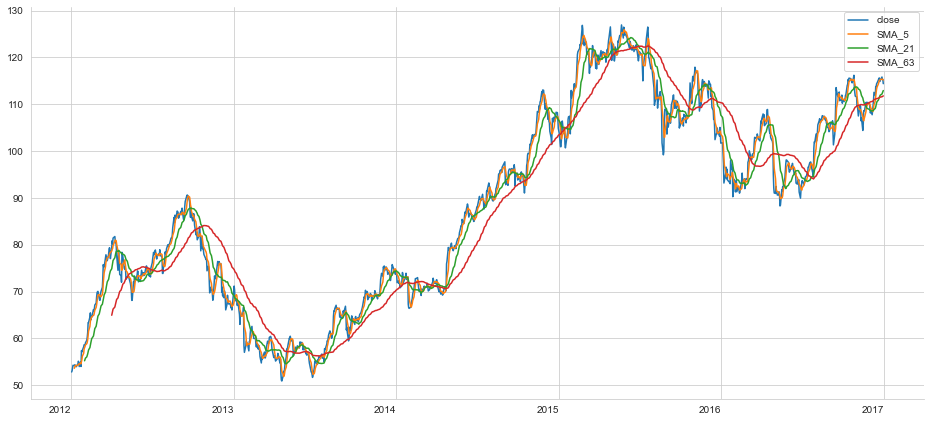

In [205]:
# 1. Moving Averages : SMA(Simple Moving Average), EMA, WMA, DEMA(Double Exponential Moving Average), TEMA(Triple Exponential Moving Average), TRIMA(Triangular Moving Average), KAMA(Kaufman Adaptive Moving Average), MAMA(MESA Adaptive Moving Average), TEMA(Triple Exponential Moving Average)

# 1-1. Simple Moving Average (SMA)
df = price_sample.loc['2012': '2016', ['close']] # sample ticker : AAPL
for t in [5, 21, 63]:
    df[f'SMA_{t}'] = talib.SMA(df.close, timeperiod=t)
ax = df.plot(figsize=(16, 8), rot=0)
sns.despine()
ax.set_xlabel('');

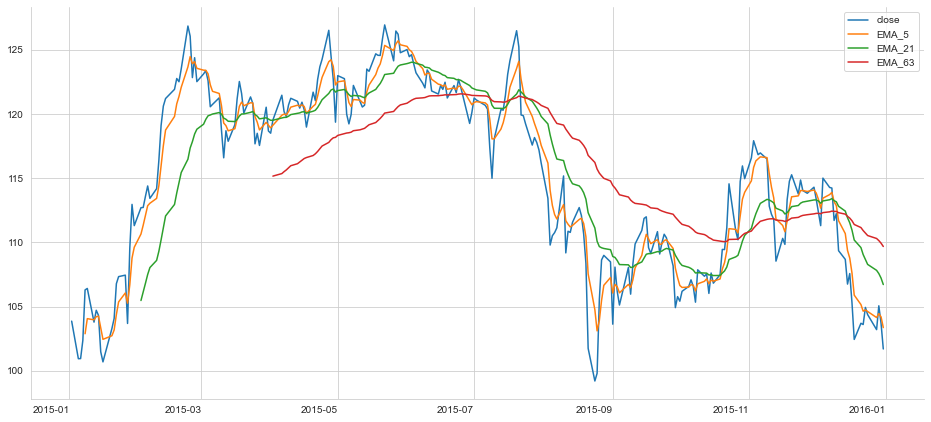

In [206]:
# 1-2. Exponential Moving Average (EMA)
df = price_sample.loc['2015', ['close']]
for t in [5, 21, 63]:
    df[f'EMA_{t}'] = talib.EMA(df.close, timeperiod=t)
ax = df.plot(figsize=(16, 8), rot=0)
sns.despine()
ax.set_xlabel('');

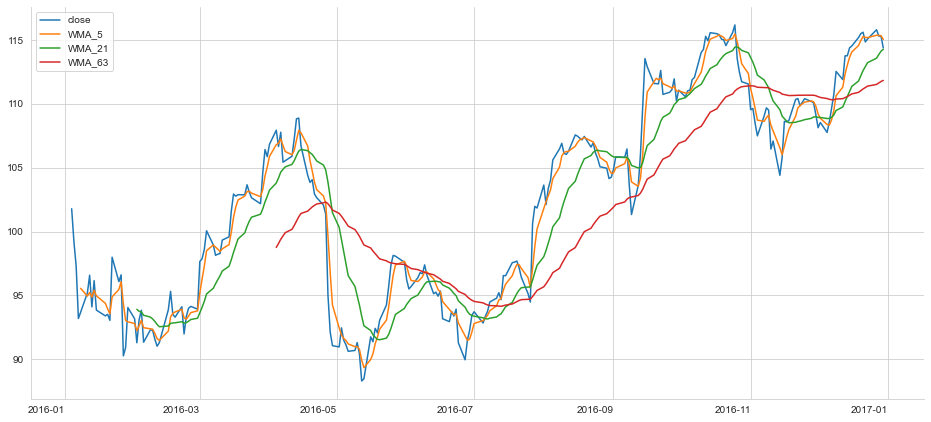

In [207]:
# 1-3. Weighted Moving Average (WMA)
df = price_sample.loc['2016', ['close']]
for t in [5, 21, 63]:
    df[f'WMA_{t}'] = talib.WMA(df.close, timeperiod=t)
ax = df.plot(figsize=(16, 8), rot=0)
sns.despine()
ax.set_xlabel('');

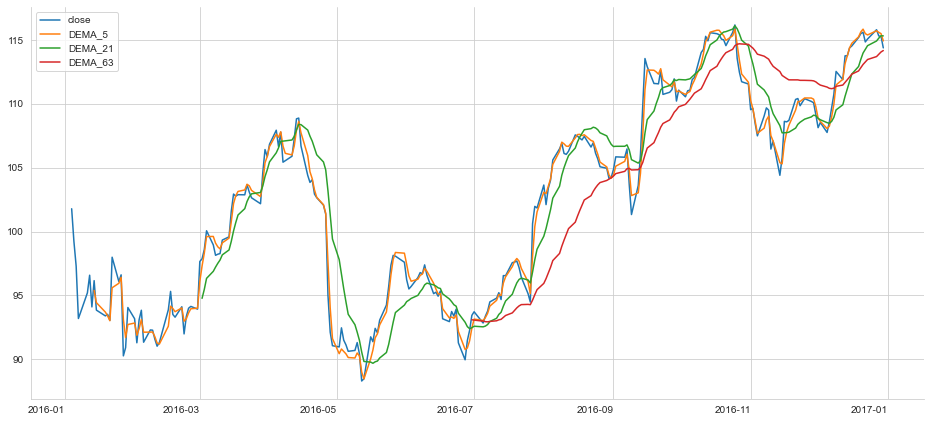

In [208]:
# 1-4. Double Exponential Moving Average (DEMA) : to react faster to changes in price
# DEMA needs 2N-1 samples to start producing values
df = price_sample.loc['2016', ['close']]
for t in [5, 21, 63]:
    df[f'DEMA_{t}'] = talib.DEMA(df.close, timeperiod=t)
ax = df.plot(figsize=(16, 8), rot=0)
sns.despine()
ax.set_xlabel('');

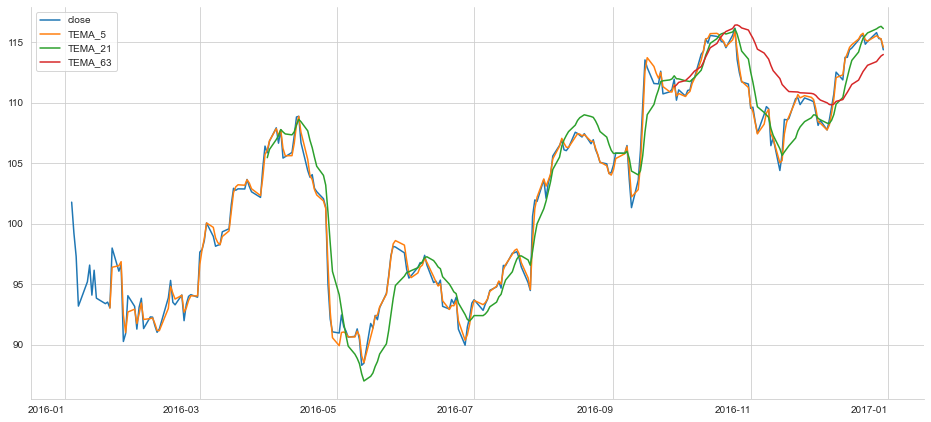

In [209]:
# 1-5. Triple Exponential Moving Average (TEMA) : to react even faster to changes in price and indicate short-term price direction
# TEMA needs 3N-2 samples to start producing values
df = price_sample.loc['2016', ['close']]
for t in [5, 21, 63]:
    df[f'TEMA_{t}'] = talib.TEMA(df.close, timeperiod=t)
ax = df.plot(figsize=(16, 8), rot=0)
sns.despine()
ax.set_xlabel('');

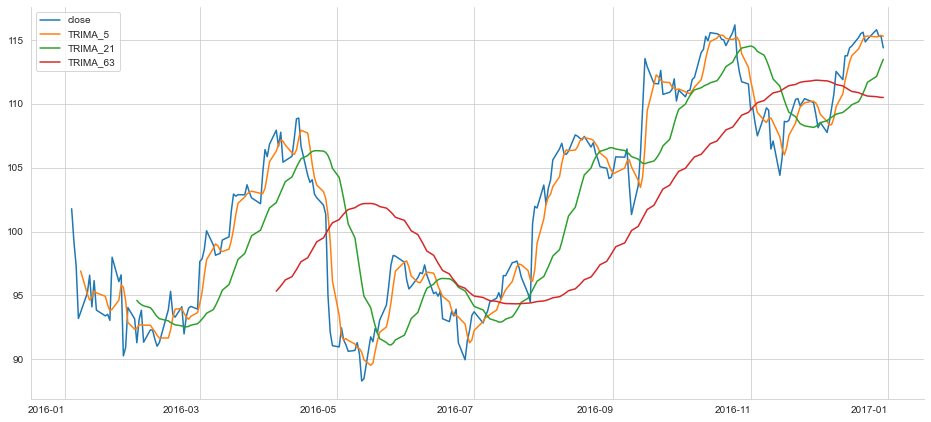

In [210]:
# Triangular Moving Average (TRIMA) : a weighted average of the last N SMA(N)t values
df = price_sample.loc['2016', ['close']]
for t in [5, 21, 63]:
    df[f'TRIMA_{t}'] = talib.TRIMA(df.close, timeperiod=t)
ax = df.plot(figsize=(16, 8), rot=0)
sns.despine()
ax.set_xlabel('');

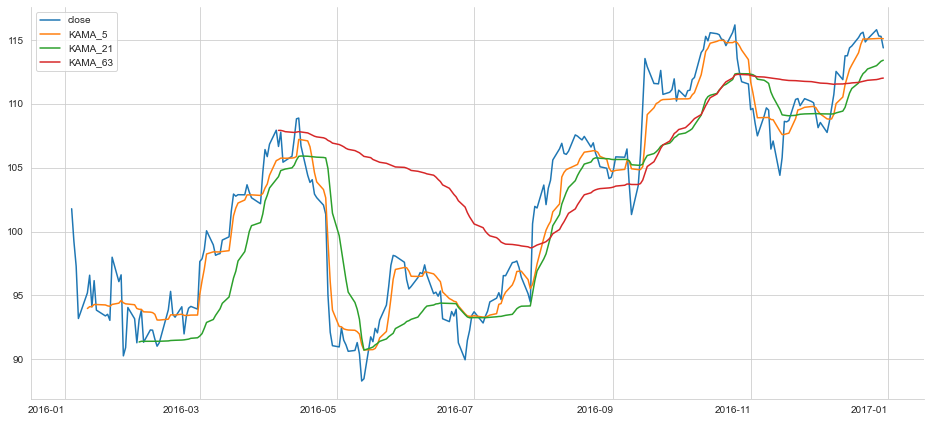

In [211]:
# 1-6. Kaufman Adaptive Moving Average (KAMA) : to take into account changes in market volatility
df = price_sample.loc['2016', ['close']]
for t in [5, 21, 63]:
    df[f'KAMA_{t}'] = talib.KAMA(df.close, timeperiod=t)
ax = df.plot(figsize=(16, 8), rot=0)
sns.despine()
ax.set_xlabel('');

len(talib.MAMA) : 2


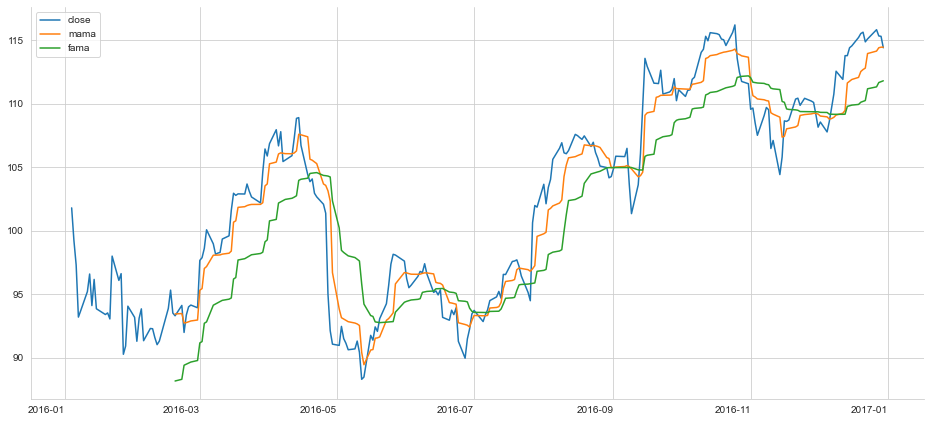

In [212]:
# 1-7. MESA(Maximum Entropy Spectral Analysis) Adaptive Moving Average (MAMA) : an exponential moving average that adapts to price movement based on the rate change of phase, as measured by the Hilbert Transform discriminator
df = price_sample.loc['2016', ['close']]
print(f'len(talib.MAMA) : {len(talib.MAMA(df.close, fastlimit=.5, slowlimit=.05))}')

mama, fama = talib.MAMA(df.close, fastlimit=.5, slowlimit=.05)
df['mama'] = mama # upward trend if MAMA > FAMA : maybe long position
df['fama'] = fama # downward trend if MAMA < FAMA : maybe short position
ax = df.plot(figsize=(16, 8), rot=0)
sns.despine()
ax.set_xlabel('');

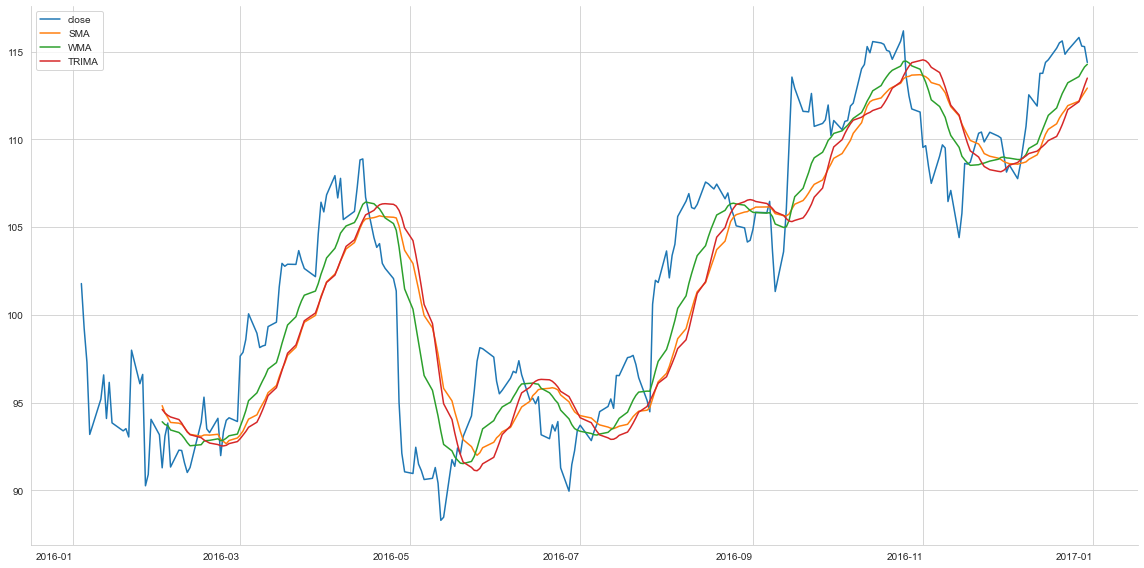

In [213]:
# Comparison Above MAs
df = price_sample.loc['2016', ['close']]
t = 21 # comparison indicators by 21 time period
df['SMA'] = talib.SMA(df.close, timeperiod=t)
df['WMA'] = talib.WMA(df.close, timeperiod=t)
df['TRIMA'] = talib.TRIMA(df.close, timeperiod=t)

ax = df[['close', 'SMA', 'WMA', 'TRIMA']].plot(figsize=(16, 8), rot=0)

sns.despine()
ax.set_xlabel('')
plt.tight_layout();

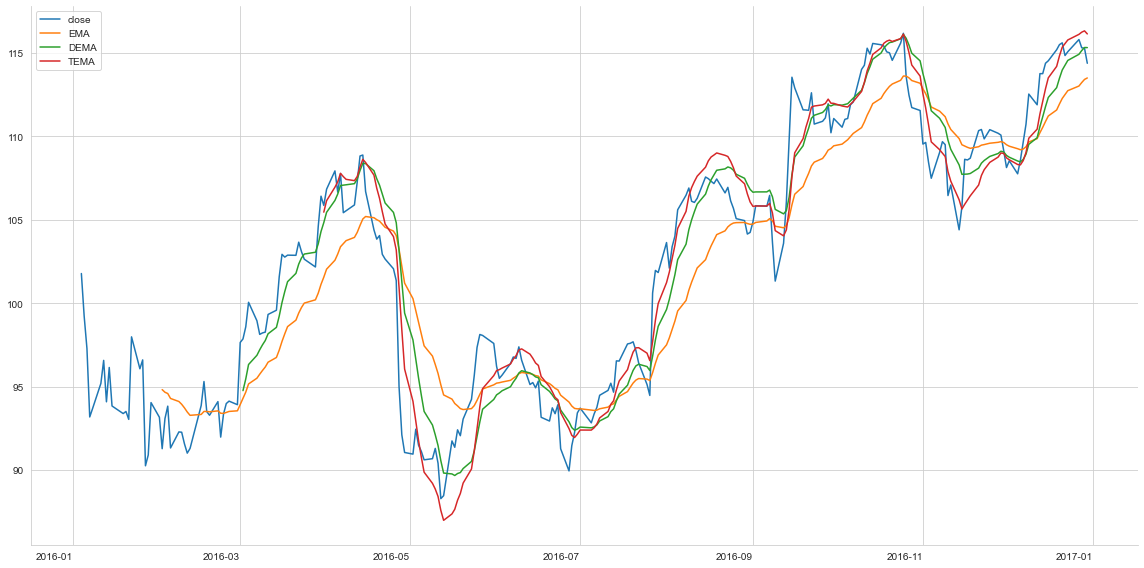

In [214]:
df['EMA'] = talib.EMA(df.close, timeperiod=t)
df['DEMA'] = talib.DEMA(df.close, timeperiod=t)
df['TEMA'] = talib.TEMA(df.close, timeperiod=t)

ax = df[['close', 'EMA', 'DEMA', 'TEMA']].plot(figsize=(16, 8), rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

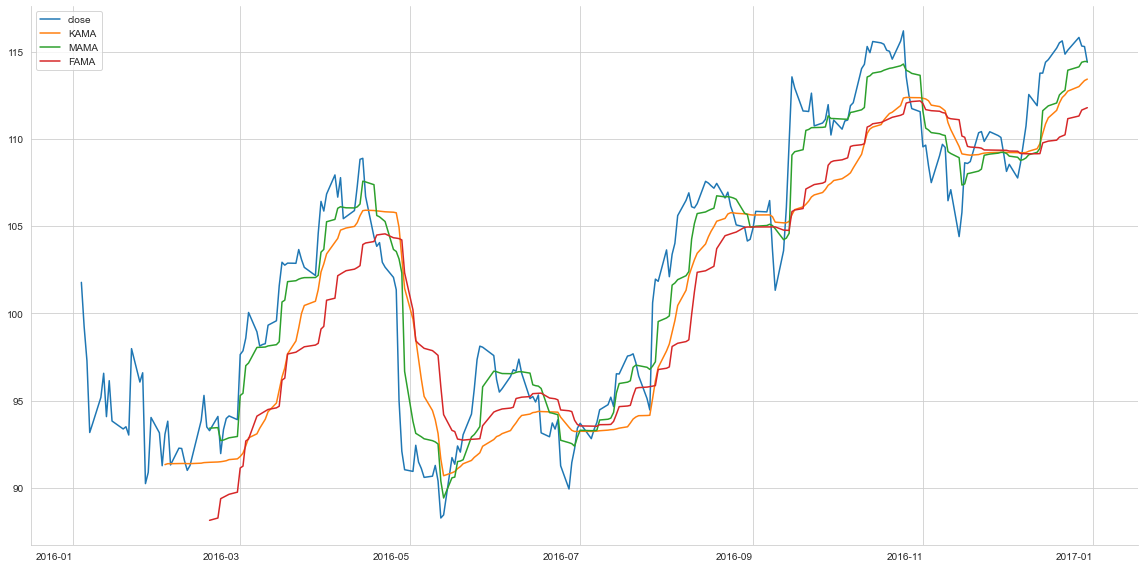

In [215]:
df['KAMA'] = talib.KAMA(df.close, timeperiod=t)
mama, fama = talib.MAMA(df.close, fastlimit=.5, slowlimit=.05)
df['MAMA'] = mama
df['FAMA'] = fama
ax = df[['close', 'KAMA', 'MAMA', 'FAMA']].plot(figsize=(16, 8), rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

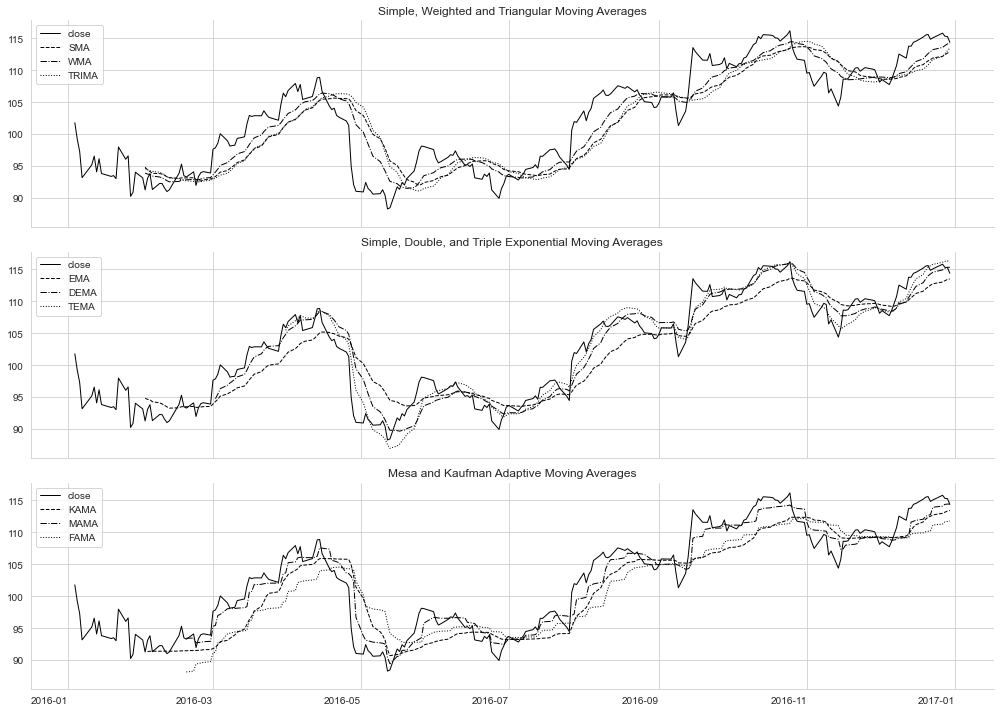

In [216]:
fig, axes = plt.subplots(nrows=3, figsize=(14, 10), sharex=True, sharey=True)


df[['close', 'SMA', 'WMA', 'TRIMA']].plot(rot=0, ax=axes[0],
                                          title='Simple, Weighted and Triangular Moving Averages',
                                          lw=1, style=['-', '--', '-.', ':'], c='k')
df[['close', 'EMA', 'DEMA', 'TEMA']].plot(rot=0, ax=axes[1],
                                          title='Simple, Double, and Triple Exponential Moving Averages',
                                          lw=1, style=['-', '--', '-.', ':'], c='k')

df[['close', 'KAMA', 'MAMA', 'FAMA']].plot(rot=0, ax=axes[2],
                                          title='Mesa and Kaufman Adaptive Moving Averages',
                                          lw=1, style=['-', '--', '-.', ':'], c='k')
axes[2].set_xlabel('')
sns.despine()
plt.tight_layout();

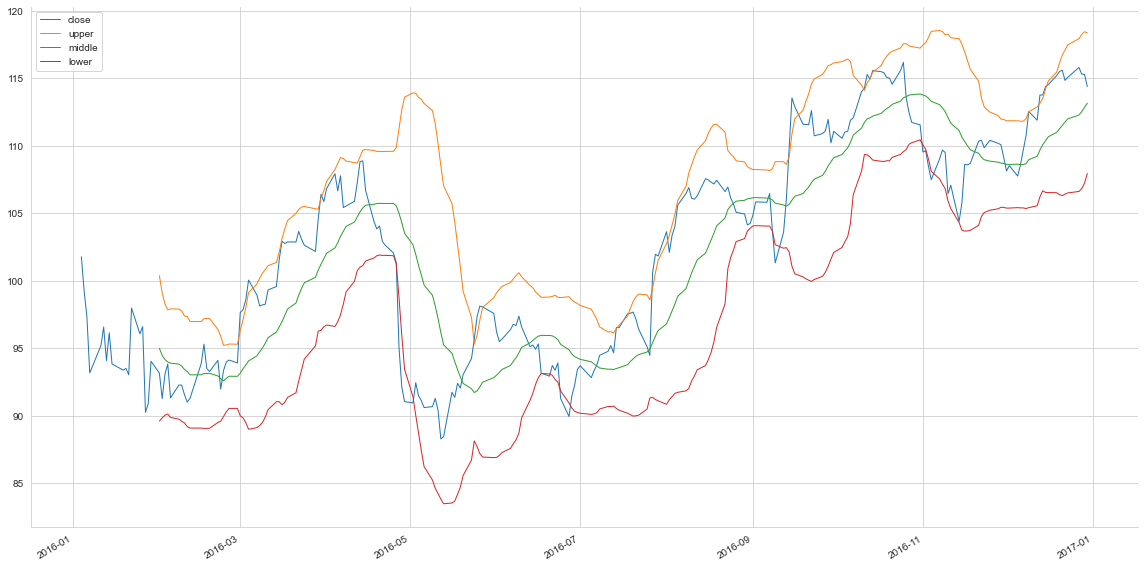

In [217]:
# 2. Overlap Studies : BBANDS, HT_TRENDLINE, MAVP, MA, MIDPOINT, MIDPRICE, SAR, SAREXT

# 2-1. Bollinger Bands : combine an MA with an upper band and a lower band representing the moving standard deviation
# matype(talib.MA_Type)
#   0: 'Simple Moving Average',
#   1: 'Exponential Moving Average',
#   2: 'Weighted Moving Average',
#   3: 'Double Exponential Moving Average',
#   4: 'Triple Exponential Moving Average',
#   5: 'Triangular Moving Average',
#   6: 'Kaufman Adaptive Moving Average',
#   7: 'MESA Adaptive Moving Average',
#   8: 'Triple Generalized Double Exponential Moving Average'
s = talib.BBANDS(df.close,   # Number of periods
                 timeperiod=20,
                 nbdevup=2,    # Deviation multiplier for lower band(2 standard deviation : 95.4%)
                 nbdevdn=2,    # Deviation multiplier for upper band
                 matype=0)
bb_bands = ['upper', 'middle', 'lower']
df = price_sample.loc['2016', ['close']] # price_sample is AAPL
df = df.assign(**dict(zip(bb_bands, s)))
ax = df.loc[:, ['close'] + bb_bands].plot(figsize=(16, 8), lw=1)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [218]:
df.columns

Index(['close', 'upper', 'middle', 'lower'], dtype='object')

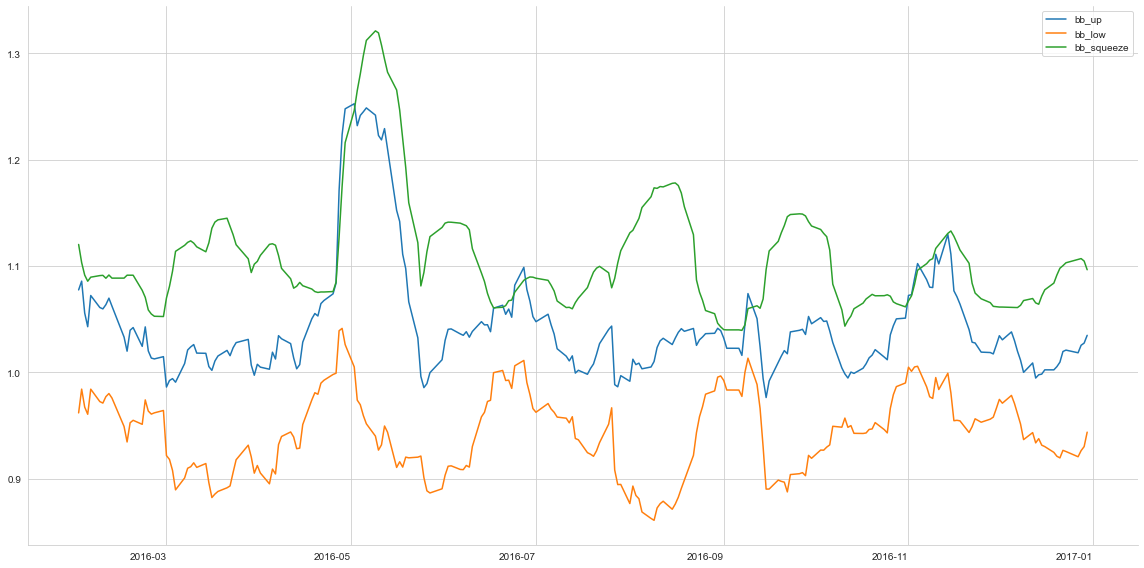

In [219]:
# Bollinger Bands - Normalized squeeze & mean reversion indicators
fig, ax = plt.subplots(figsize=(16,8))
df.upper.div(df.close).plot(ax=ax, label='bb_up')
df.lower.div(df.close).plot(ax=ax, label='bb_low')
df.upper.div(df.lower).plot(ax=ax, label='bb_squeeze', rot=0)

plt.legend()
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [220]:
def compute_bb_indicators(close, timeperiod=20, matype=0):
    high, mid, low = talib.BBANDS(close, timeperiod=20, matype=matype)
    bb_up = high / close -1
    bb_low = low / close -1
    squeeze = (high - low) / close # BBands get narrower
    return pd.DataFrame({'BB_UP': bb_up, 'BB_LOW': bb_low, 'BB_SQUEEZE': squeeze}, index=close.index)
data = (data.join(data.groupby(level='ticker').close.apply(compute_bb_indicators)))

In [221]:
data.tail(10)

open       high        low      close     volume  \
ticker date                                                                
ZION   2016-12-15  42.547078  43.351915  42.209245  42.765676  3615038.0   
       2016-12-16  42.517269  42.954465  41.642878  41.762113  5517196.0   
       2016-12-19  41.821731  42.447715  41.533579  42.427843  2212274.0   
       2016-12-20  43.004146  43.808983  42.686185  43.630130  3220373.0   
       2016-12-21  43.650003  43.709620  43.083636  43.361851  2647594.0   
       2016-12-22  43.341979  43.669875  42.934592  43.461214  1555955.0   
       2016-12-23  43.500959  43.659939  43.309189  43.580449  1243449.0   
       2016-12-27  43.818919  43.868601  43.391660  43.650003  1096332.0   
       2016-12-28  43.749366  43.749366  42.904783  43.004146  1055176.0   
       2016-12-29  42.994210  43.361851  42.358289  42.517269  1551615.0   

                      marketcap  sector    ret_01    ret_02    ret_03  ...  \
ticker date                                                            ...   
ZION   2016-12-15  1.032000e+10     0.0  0.019905  0.019181  0.013421  ...   
       2016-12-16  1.032000e+10     0.0 -0.023467 -0.004028 -0.004736  ...   
       2016-12-19  1.032000e+10     0.0  0.015941 -0.007900  0.011848  ...   
       2016-12-20  1.032000e+10     0.0  0.028337  0.044730  0.020214  ...   
       2016-12-21  1.032000e+10     0.0 -0.006149  0.022014  0.038306  ...   
       2016-12-22  1.032000e+10     0.0  0.002291 -0.003872  0.024356  ...   
       2016-12-23  1.032000e+10     0.0  0.002743  0.005041 -0.001139  ...   
       2016-12-27  1.032000e+10     0.0  0.001596  0.004344  0.006645  ...   
       2016-12-28  1.032000e+10     0.0 -0.014796 -0.013224 -0.010517  ...   
       2016-12-29  1.032000e+10     0.0 -0.011322 -0.025950 -0.024396  ...   

                     ret_10    ret_21    ret_42    ret_63   ret_126   ret_252  \
ticker date                                                                     
ZION   2016-12-15  0.065083  0.110423  0.407165  0.442461  0.624111  0.540911   
       2016-12-16  0.044483  0.121997  0.351219  0.408612  0.583620  0.529143   
       2016-12-19  0.053021  0.126352  0.334234  0.432504  0.599866  0.614590   
       2016-12-20  0.047471  0.149176  0.363962  0.467203  0.636052  0.656622   
       2016-12-21  0.031922  0.132330  0.352222  0.444216  0.557280  0.622793   
       2016-12-22  0.015085  0.131402  0.351559  0.431919  0.737979  0.596533   
       2016-12-23  0.014573  0.121166  0.370053  0.464067  0.868337  0.594574   
       2016-12-27  0.034377  0.123529  0.369678  0.447598  0.809939  0.605208   
       2016-12-28  0.024864  0.126790  0.339410  0.405838  0.740346  0.571790   
       2016-12-29  0.013981  0.111429  0.336213  0.404950  0.711057  0.573229   

                    ret_fwd     BB_UP    BB_LOW  BB_SQUEEZE  
ticker date                                                  
ZION   2016-12-15 -0.023467  0.026306 -0.144545    0.170850  
       2016-12-16  0.015941  0.052452 -0.115668    0.168120  
       2016-12-19  0.028337  0.039032 -0.122123    0.161154  
       2016-12-20 -0.006149  0.017677 -0.141362    0.159039  
       2016-12-21  0.002291  0.028567 -0.129231    0.157798  
       2016-12-22  0.002743  0.030701 -0.125145    0.155846  
       2016-12-23  0.001596  0.031284 -0.120090    0.151374  
       2016-12-27 -0.014796  0.028935 -0.108220    0.137155  
       2016-12-28 -0.011322  0.038593 -0.077988    0.116581  
       2016-12-29  0.005842  0.046816 -0.056749    0.103565  

[10 rows x 22 columns]

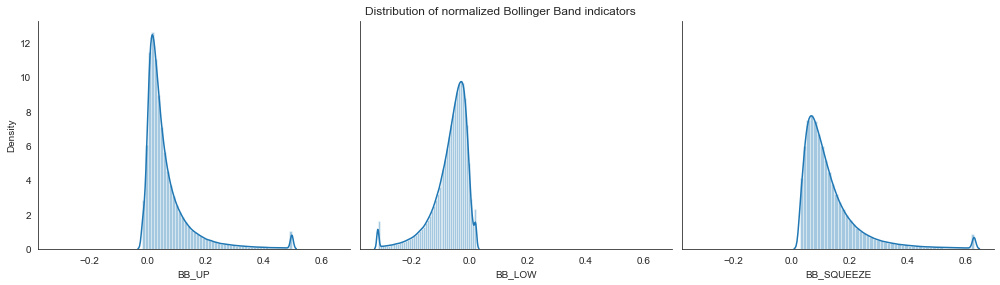

In [222]:
# Visualize Distribution
bb_indicators = ['BB_UP', 'BB_LOW', 'BB_SQUEEZE']
q = .01
with sns.axes_style('white'):
    fig, axes = plt.subplots(ncols=3, figsize=(14, 4), sharey=True, sharex=True)
    df_ = data[bb_indicators]
    df_ = df_.clip(df_.quantile(q), df_.quantile(1-q), axis=1)
    for i, indicator in enumerate(bb_indicators):
        sns.distplot(df_[indicator], ax=axes[i])
    fig.suptitle('Distribution of normalized Bollinger Band indicators', fontsize=12)

    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.93);

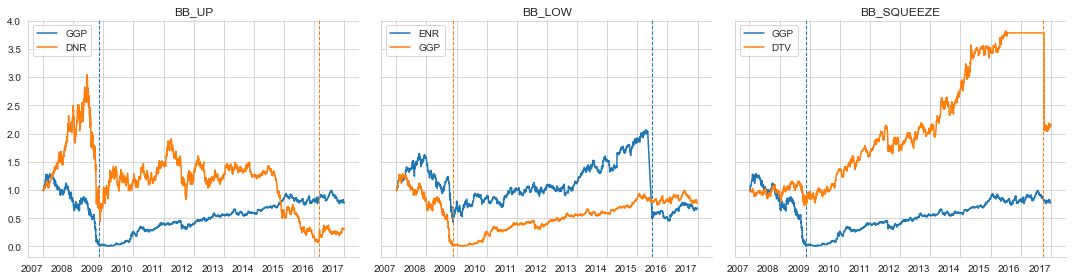

In [223]:
# Plot outlier price series
ncols = len(bb_indicators)
fig, axes = plt.subplots(ncols=ncols, figsize=(5*ncols, 4), sharey=True)
for i, indicator in enumerate(bb_indicators):
    ticker, date = data[indicator].nlargest(1).index[0]
    p = data.loc[idx[ticker, :], :].close.reset_index('ticker', drop=True)
    p = p.div(p.dropna().iloc[0])
    p.plot(ax=axes[i], label=ticker, rot=0)
    c = axes[i].get_lines()[-1].get_color()
    axes[i].axvline(date, ls='--', c=c, lw=1)
    ticker, date = data[indicator].nsmallest(1).index[0]
    p = data.loc[idx[ticker, :], :].close.reset_index('ticker', drop=True)
    p = p.div(p.dropna().iloc[0])
    p.plot(ax=axes[i], label=ticker, rot=0)
    c = axes[i].get_lines()[-1].get_color()
    axes[i].axvline(date, ls='--', c=c, lw=1)
    axes[i].set_title(indicator.upper())
    axes[i].legend()
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout();

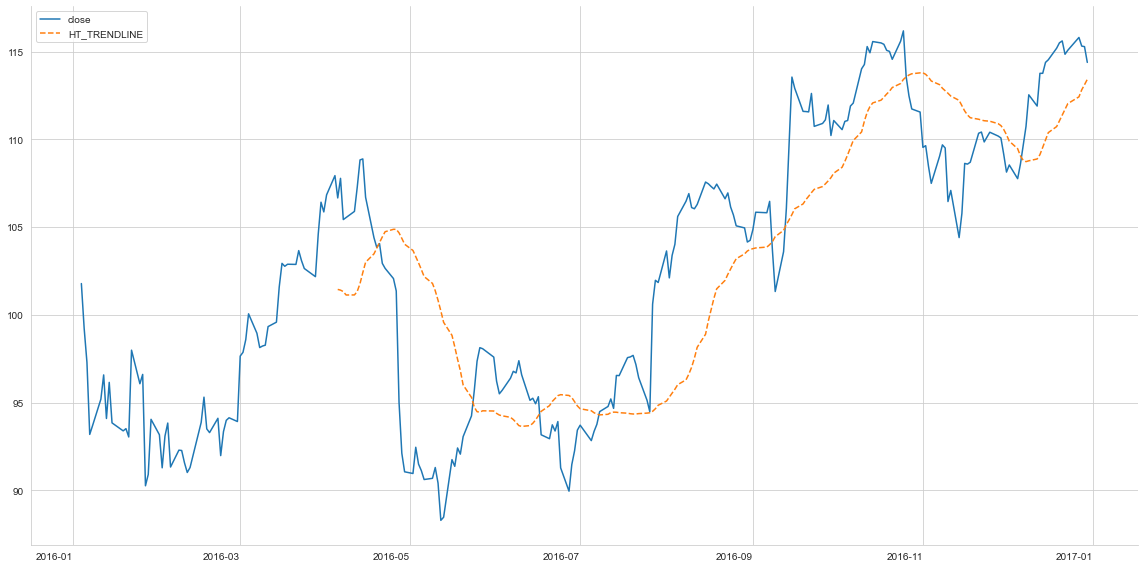

In [224]:
# 2-2. Hilbert Transform - Instantaneous Trendline
df = price_sample.loc['2016', ['close']]
df['HT_TRENDLINE'] = talib.HT_TRENDLINE(df.close)
ax = df.plot(figsize=(16, 8), style=['-', '--'], rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

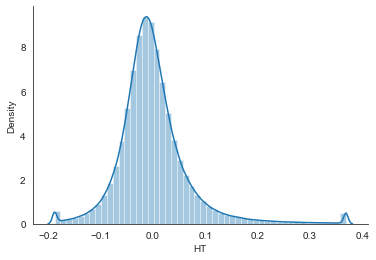

In [225]:
# Compute Hilbert-based normalized indicator
data['HT'] = (data.groupby(level='ticker', group_keys=False).close.apply(talib.HT_TRENDLINE)
              .div(data.close).sub(1))
q=0.005
with sns.axes_style('white'):
    sns.distplot(data.HT.clip(data.HT.quantile(q), data.HT.quantile(1-q)))
    sns.despine();

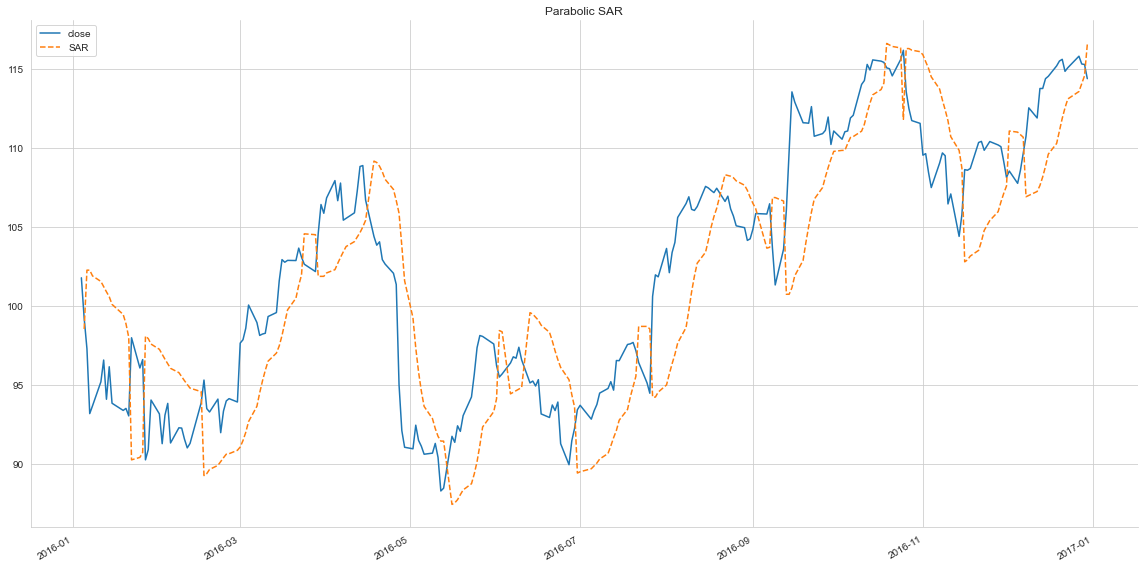

In [226]:
# 2-3. Parabolic SAR : to identify trend reversals(=trend-following (lagging) indicator that can be used to set a trailing stop loss or determine entry or exit points),  less reliable in a flat or range-bound market
# Parabolic SAR > close : downward trend
# Parabolic SAR < close : upward trend
df = price_sample.loc['2016', ['close', 'high', 'low']]
df['SAR'] = talib.SAR(df.high, df.low, acceleration=0.02, maximum=0.2)
ax = df[['close', 'SAR']].plot(figsize=(16, 8), style=['-', '--'], title='Parabolic SAR')
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

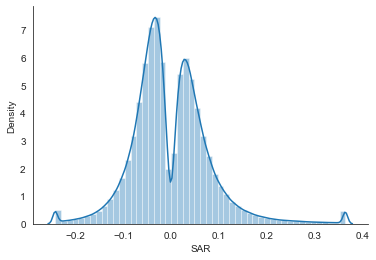

In [227]:
# Normalized SAR indicator : SARt = SAR(t-1) + alpha(EP - SAR(t-1))
# EP : highest value reached by the price during the current uptrend—or lowest value during a downtrend
# alpha(=acceleration) : update whenever EP reaches the record
# maximum : maximum of acceleration
def compute_sar_indicator(x, acceleration=.02, maximum=0.2):
    sar = talib.SAR(x.high, x.low, acceleration=acceleration, maximum=maximum)
    return sar/x.close - 1

data['SAR'] = (data.groupby(level='ticker', group_keys=False).apply(compute_sar_indicator))
q=0.005
with sns.axes_style('white'):
    sns.distplot(data.SAR.clip(data.SAR.quantile(q), data.SAR.quantile(1-q)))
    sns.despine()

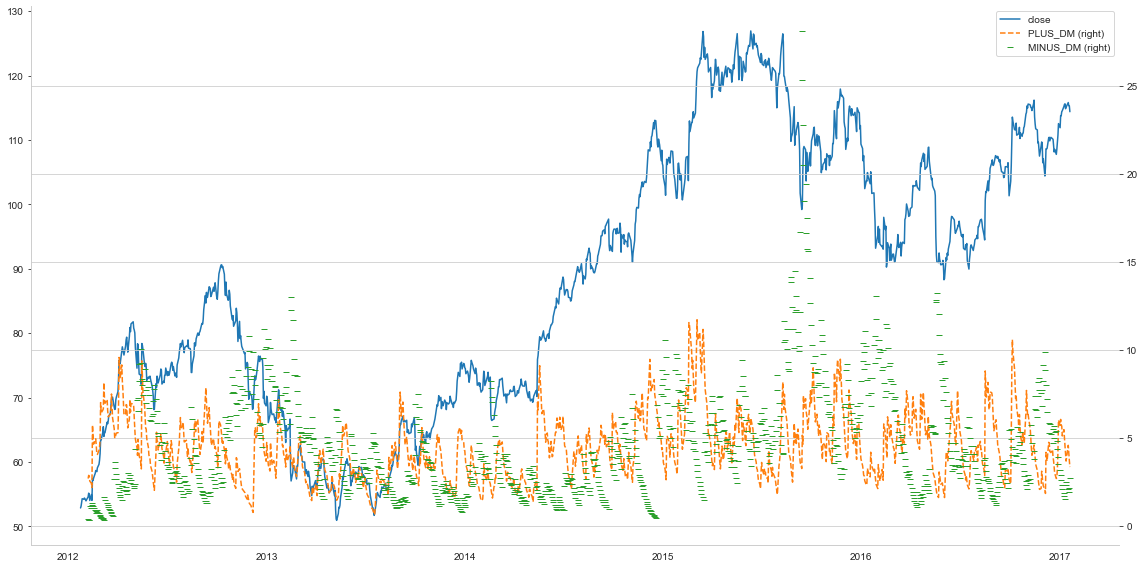

In [228]:
# 3. Momentum Indicators: PLUS_DM(Directional Movement), MINUS_DM, PLUS_DI(Directional Indicator), MINUS_DI, DX(Directional Movement Index), ADX(Average Directional Movement Index), ADXR(Average Directional Movement Index Rating), APO(Absolute Price Oscillator), PPO(Percentage Price Oscillator), AROON, AROONOSC(Aroon Oscillator), BOP(Balance Of Power), CCI(Commodity Channel Index), CMO(Chande Momentum Oscillator), MACD, MACDEXT(MACD with controllable MA type), MACDFIX(MACD Fix 12/26), MFI(Money Flow Index), MOM(Momentum). RSI, STOCH, STOCHF(Stochastic Fast), STOCHRSI(Stochastic Relative Strength Index), TRIX(1-day Rate-Of-Change (ROC) of a Triple Smooth EMA), ULTOSC(Ultimate Oscillator), WILLR(Williams' %R)

# 3-1. Average Directional Movement Index (ADX)
df = price_sample.loc['2012': '2016', ['high', 'low', 'close']]
df['PLUS_DM'] = talib.PLUS_DM(df.high, df.low, timeperiod=10)
df['MINUS_DM'] = talib.MINUS_DM(df.high, df.low, timeperiod=10)
ax = df[['close', 'PLUS_DM', 'MINUS_DM']].plot(figsize=(16, 8), secondary_y=['PLUS_DM', 'MINUS_DM'],
                                               style=['-', '--', '_'], rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

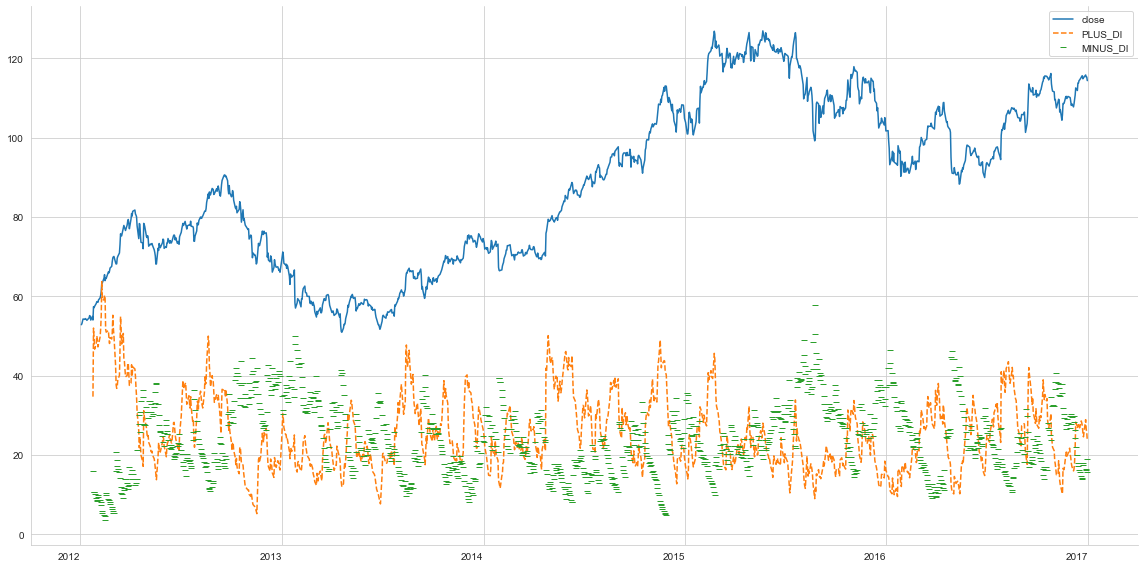

In [229]:
# 3-1-1. Plus/Minus Directional Index (PLUS_DI/MINUS_DI) : simple MAs of PLUS_DM and MINUS_DM each divided by the average true range (ATR)
df = price_sample.loc['2012': '2016', ['high', 'low', 'close']]
df['PLUS_DI'] = talib.PLUS_DI(df.high, df.low, df.close, timeperiod=14)
df['MINUS_DI'] = talib.MINUS_DI(df.high, df.low, df.close, timeperiod=14)
ax = df[['close', 'PLUS_DI', 'MINUS_DI']].plot(figsize=(16, 8), style=['-', '--', '_'], rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

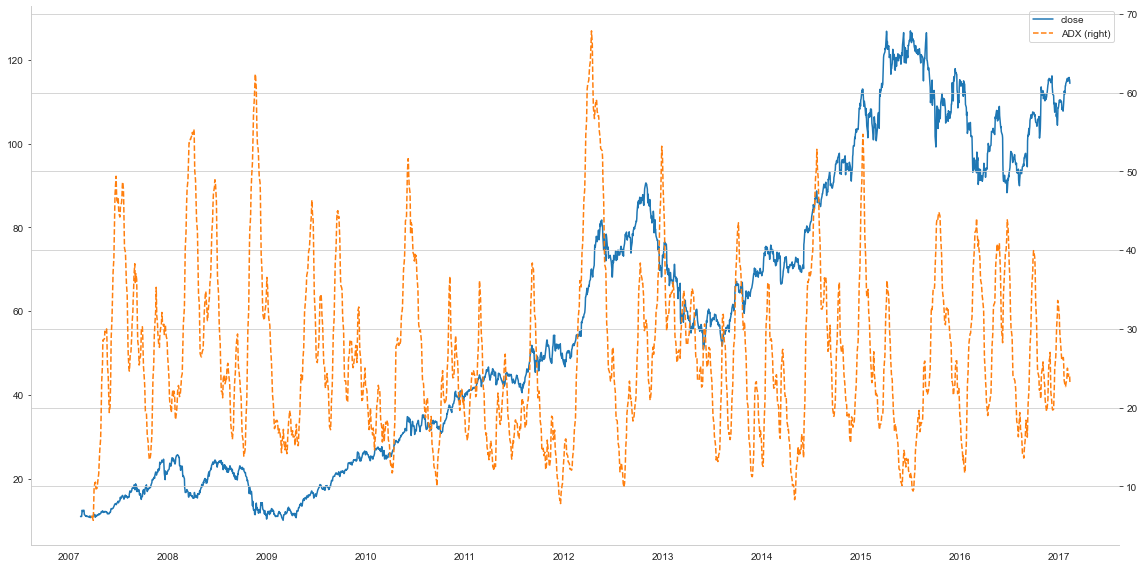

In [230]:
# 3-1-2. Average directional movement index (ADX) : MA of the absolute value of the difference between PLUS_DI and MINUS_DI, divided by their sum(aka. trend check indicator)
df = price_sample.loc[:, ['high', 'low', 'close']]
df['ADX'] = talib.ADX(df.high, df.low, df.close, timeperiod=14)
ax = df[['close', 'ADX']].plot(figsize=(16, 8), secondary_y='ADX', style=['-', '--'], rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

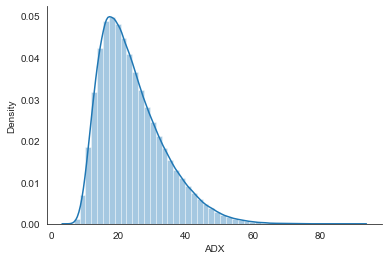

In [231]:
def compute_adx(x, timeperiod=14):
    return talib.ADX(x.high, x.low, x.close, timeperiod=timeperiod)
data['ADX'] = (data.groupby(level='ticker', group_keys=False).apply(compute_adx))

with sns.axes_style("white"):
    sns.distplot(data.ADX)
    sns.despine();

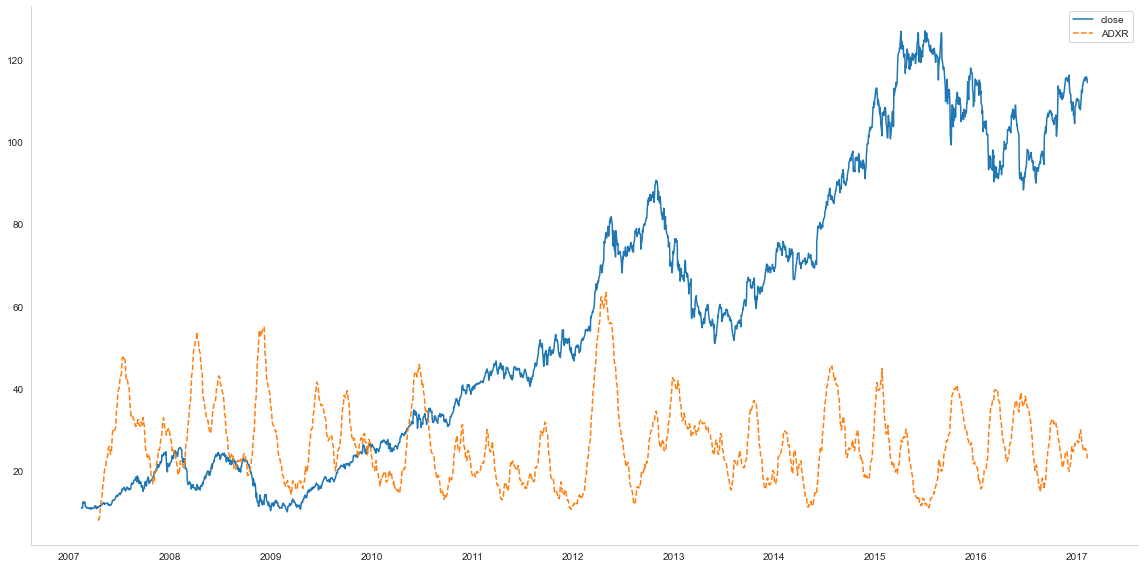

In [232]:
# 3-1-3. Average Directional Movement Index Rating(ADXR)
# ADXR >= 25 : recommending trend buying strategy
# ADXR < 20 : recommending range-bound market strategy
df = price_sample.loc[:, ['high', 'low', 'close']]
df['ADXR'] = talib.ADXR(df.high, df.low, df.close, timeperiod=14)
ax = df[['close', 'ADXR']].plot(figsize=(16, 8), secondary_y='ADX', style=['-', '--'], rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

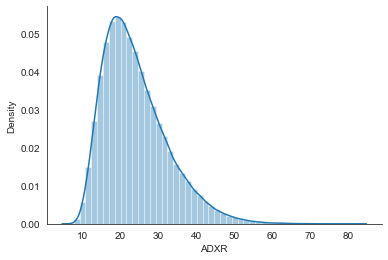

In [233]:
def compute_adxr(x, timeperiod=14):
    return talib.ADXR(x.high, x.low, x.close, timeperiod=timeperiod)
data['ADXR'] = (data.groupby(level='ticker', group_keys=False).apply(compute_adxr))
with sns.axes_style('white'):
    sns.distplot(data.ADXR)
    sns.despine();

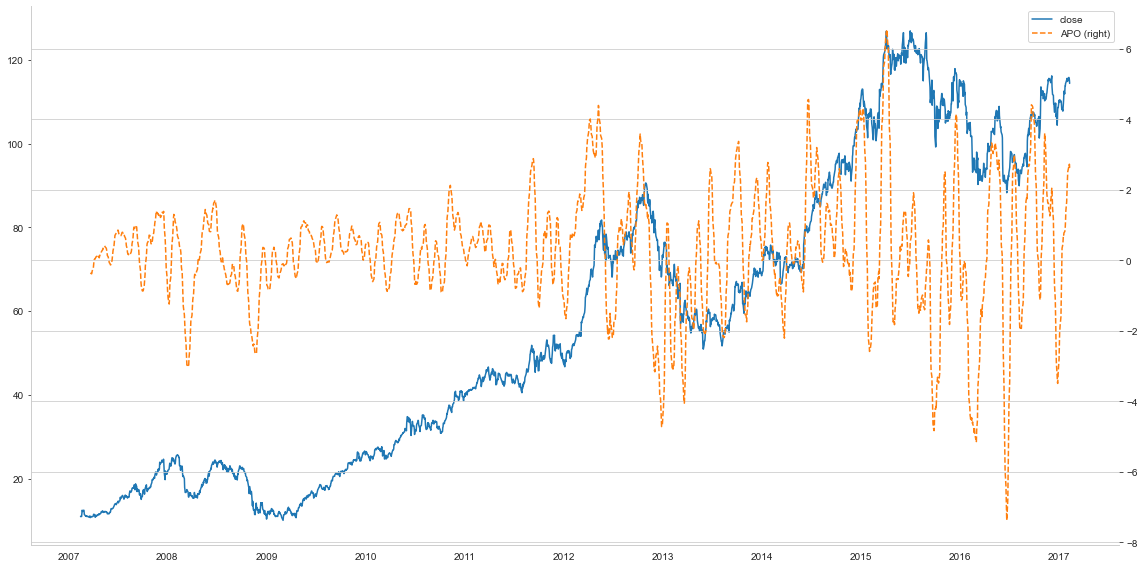

In [234]:
# 3-2. Absolute Price Oscillator (APO)
df = price_sample.loc[:, ['close']]
df['APO'] = talib.APO(df.close, fastperiod=12, slowperiod=26, matype=0)
ax = df.plot(figsize=(16,8), secondary_y='APO', rot=0, style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

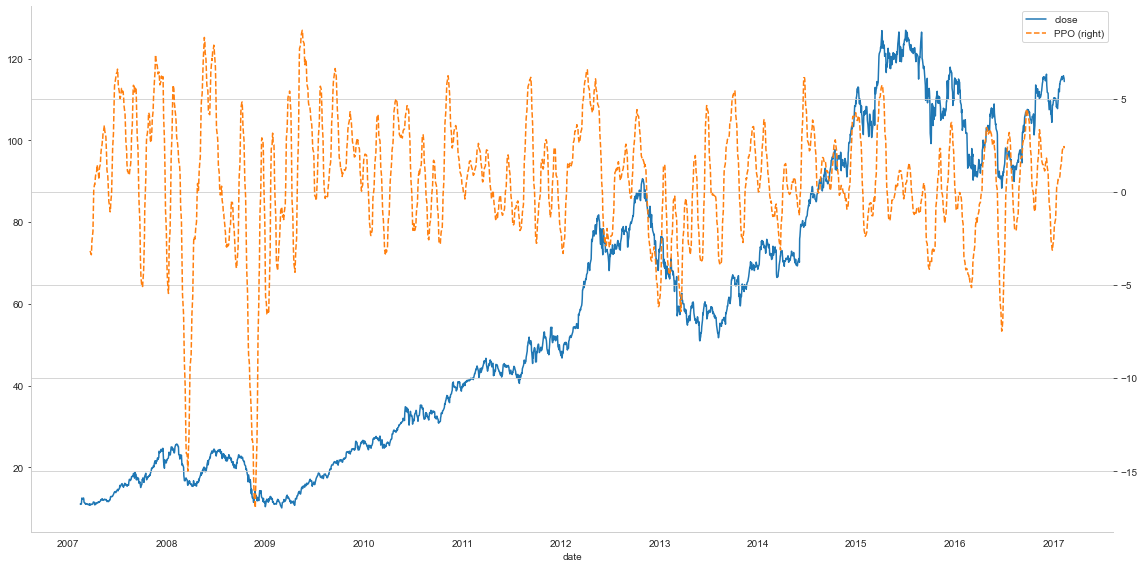

In [235]:
# 3-3. Percentage Price Oscillator (PPO)
df = price_sample.loc[:, ['close']]
df['PPO'] = talib.PPO(df.close, fastperiod=12, slowperiod=26, matype=0)
ax = df.plot(figsize=(16,8), secondary_y=['APO', 'PPO'], rot=0,  style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

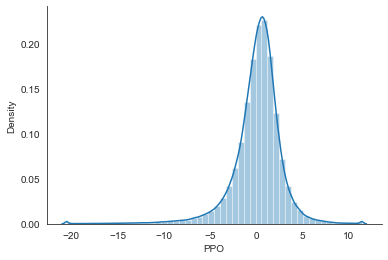

In [236]:
data['PPO'] = (data.groupby(level='ticker').close.apply(talib.PPO, fastperiod=12, slowperiod=26, matype=1))
q = 0.001
with sns.axes_style("white"):
    sns.distplot(data.PPO.clip(lower=data.PPO.quantile(q), upper=data.PPO.quantile(1-q)))
    sns.despine()

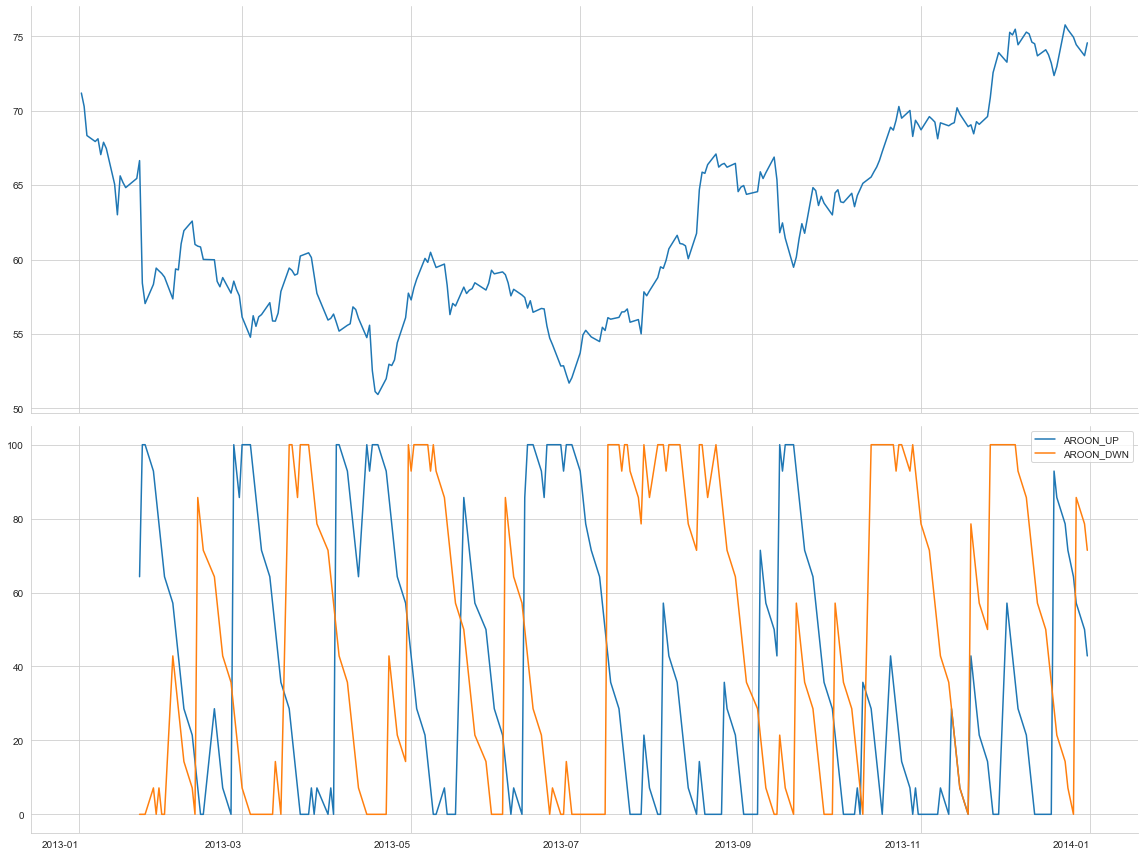

In [237]:
# 3-4. Aroon Oscillator - simply the difference between the AROON_UP and AROON_DOWN indicators and moves within the range from -100(low price) to 100(high price)

# Aroon Up/Down Indicator - measures the time between highs and the time between lows over a time period
df = price_sample.loc['2013', ['high', 'low', 'close']]
aroonup, aroondwn = talib.AROON(high=df.high, low=df.low, timeperiod=14)
df['AROON_UP'] = aroonup
df['AROON_DWN'] = aroondwn
fig, axes = plt.subplots(nrows=2, figsize=(16, 12), sharex=True)
df.close.plot(ax=axes[0], rot=0)
df[['AROON_UP', 'AROON_DWN']].plot(ax=axes[1], rot=0)

axes[1].set_xlabel('')
sns.despine()
plt.tight_layout();

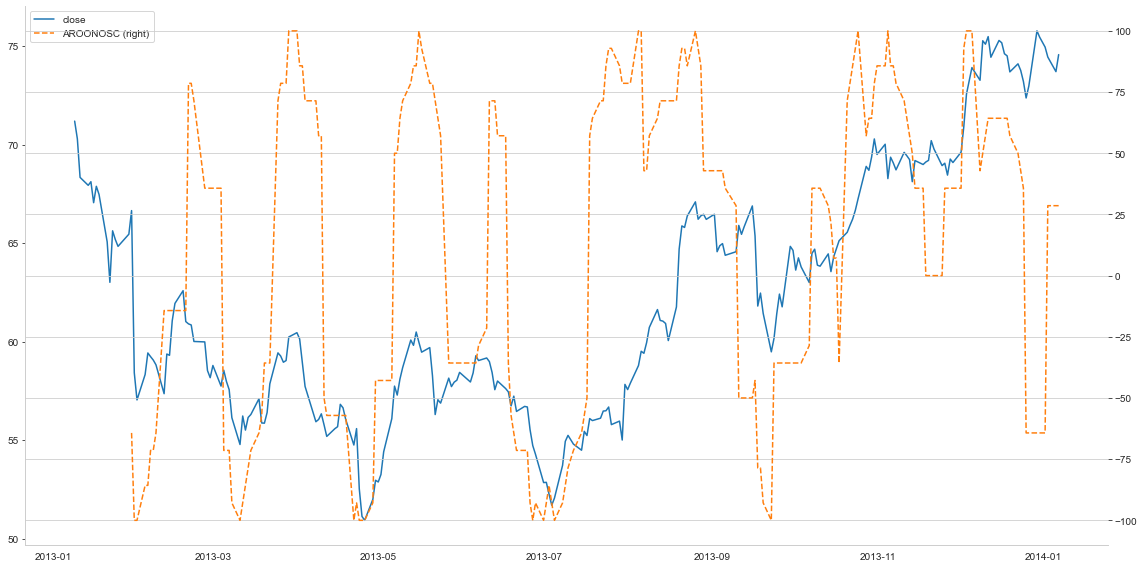

In [238]:
# Aroon Oscillator - As the lagging indicator of the price, not appropriate to utilize
df = price_sample.loc['2013', ['high', 'low', 'close']]
df['AROONOSC'] = talib.AROONOSC(high=df.high, low=df.low, timeperiod=14)
ax = df[['close', 'AROONOSC']].plot(figsize=(16,8), rot=0, style=['-', '--'], secondary_y='AROONOSC')
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

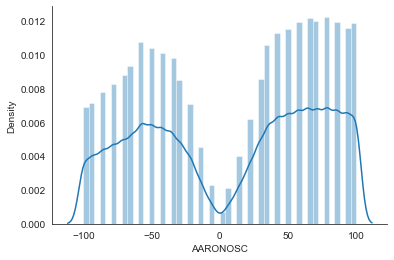

In [239]:
data['AARONOSC'] = (data.groupby('ticker', group_keys=False)
                    .apply(lambda x: talib.AROONOSC(high=x.high, low=x.low, timeperiod=14)))
with sns.axes_style("white"):
    sns.distplot(data.AARONOSC)
    sns.despine()

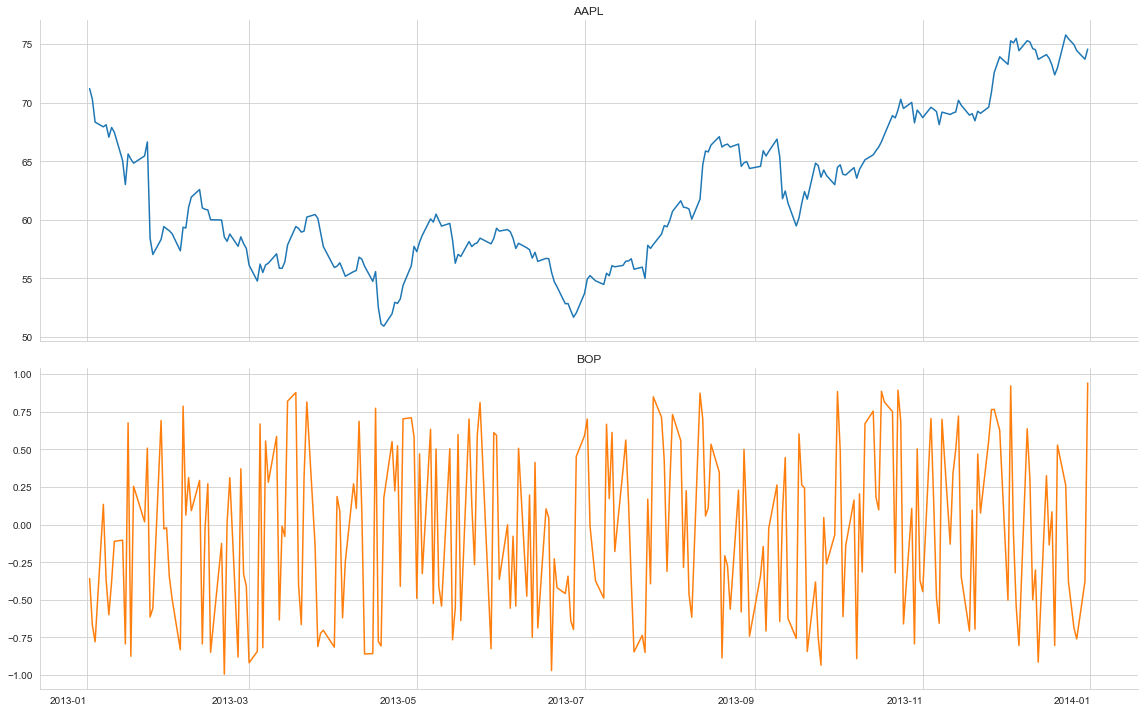

In [240]:
# 3-5. Balance Of Power (BOP) - to measure the strength of buyers relative to sellers in the market by assessing the influence of each side on the price.
# BOP = P(close) - P(open) / {P(high) - P(low)}
df = price_sample.loc['2013', ['open', 'high', 'low', 'close']]
df['BOP'] = talib.BOP(open=df.open, high=df.high, low=df.low, close=df.close)
axes = df[['close', 'BOP']].plot(figsize=(16, 10), rot=0, subplots=True, title=['AAPL', 'BOP'], legend=False)
axes[1].set_xlabel('')
sns.despine()
plt.tight_layout();

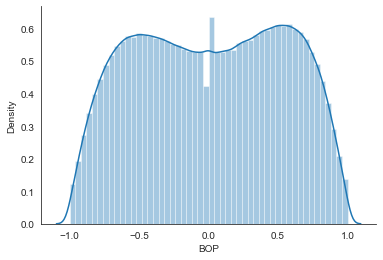

In [241]:
by_ticker = data.groupby('ticker', group_keys=False)
data['BOP'] = (by_ticker.apply(lambda x: talib.BOP(x.open, x.high, x.low, x.close)))
q = 0.0005
with sns.axes_style("white"):
    sns.distplot(data.BOP.clip(lower=data.BOP.quantile(q), upper=data.BOP.quantile(1-q)))
    sns.despine()

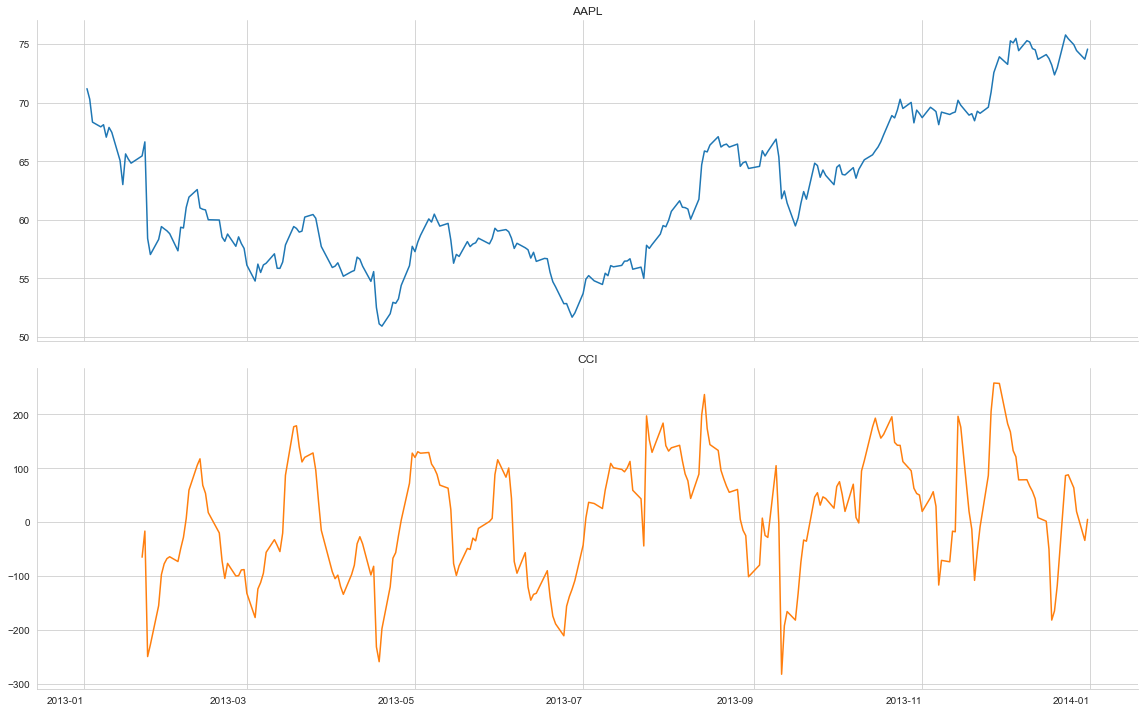

In [242]:
# 3-6. Commodity Channel Index (CCI) - measures the difference between the current typical price, computed as the average of current low, high, and close price and the historical average price, kinda lagging indicator
# CCI >= 100 : overbought, possible to mean reversion
# CCI <= -100 : oversold, possible to mean reversion
df = price_sample.loc['2013', ['high', 'low', 'close']]
df['CCI'] = talib.CCI(high=df.high, low=df.low, close=df.close, timeperiod=14)
axes = df[['close', 'CCI']].plot(figsize=(16, 10),  rot=0, subplots=True, title=['AAPL', 'CCI'], legend=False)
axes[1].set_xlabel('')
sns.despine()
plt.tight_layout()

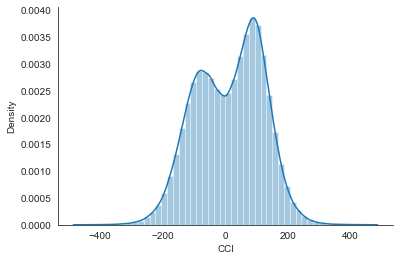

In [243]:
data['CCI'] = (by_ticker.apply(lambda x: talib.CCI(x.high, x.low, x.close, timeperiod=14)))
with sns.axes_style('white'):
    sns.distplot(data.CCI)
    sns.despine();

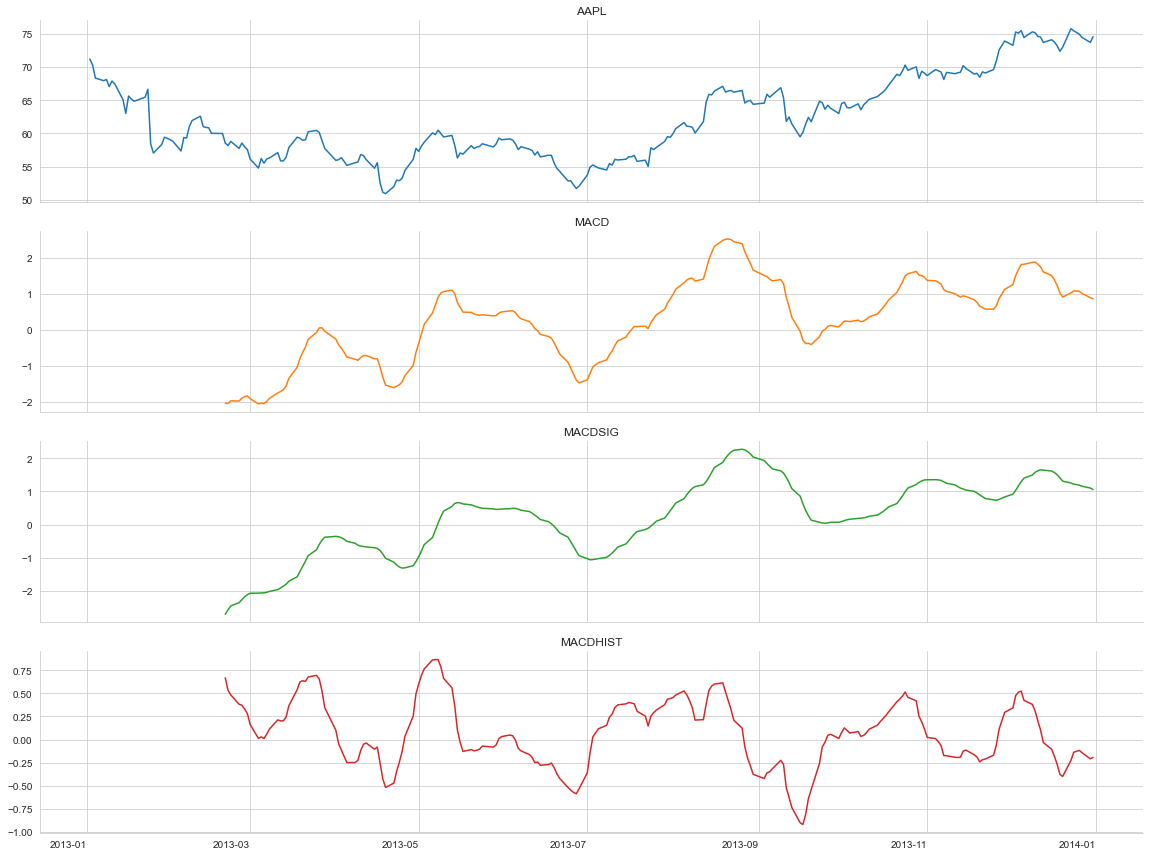

In [244]:
# 3-7. Moving Average Convergence/Divergence (MACD) : trend-following (lagging) momentum indicator that shows the relationship between two MAs of a security's price
df = price_sample.loc['2013', ['close']]
macd, macdsignal, macdhist = talib.MACD(df.close, fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd # 9-day EMA of the MACD
df['MACDSIG'] = macdsignal
df['MACDHIST'] = macdhist # measures the distance between the indicator and its signal line
axes = df.plot(figsize=(16, 12), rot=0, subplots=True, title=['AAPL', 'MACD', 'MACDSIG', 'MACDHIST'],
               legend=False)

axes[-1].set_xlabel('')
sns.despine()
plt.tight_layout()

In [245]:
def compute_macd(close, fastperiod=12, slowperiod=26, signalperiod=9):
    macd, macdsignal, macdhist = talib.MACD(close, fastperiod=fastperiod, slowperiod=slowperiod,
                                            signalperiod=signalperiod)
    return pd.DataFrame({'MACD': macd, 'MACD_SIGNAL': macdsignal, 'MACD_HIST': macdhist}, index=close.index)
data = (data.join(data.groupby(level='ticker').close.apply(compute_macd)))
macd_indicators = ['MACD', 'MACD_SIGNAL', 'MACD_HIST']
data[macd_indicators].corr()

MACD  MACD_SIGNAL  MACD_HIST
MACD         1.000000     0.955452   0.331106
MACD_SIGNAL  0.955452     1.000000   0.037857
MACD_HIST    0.331106     0.037857   1.000000

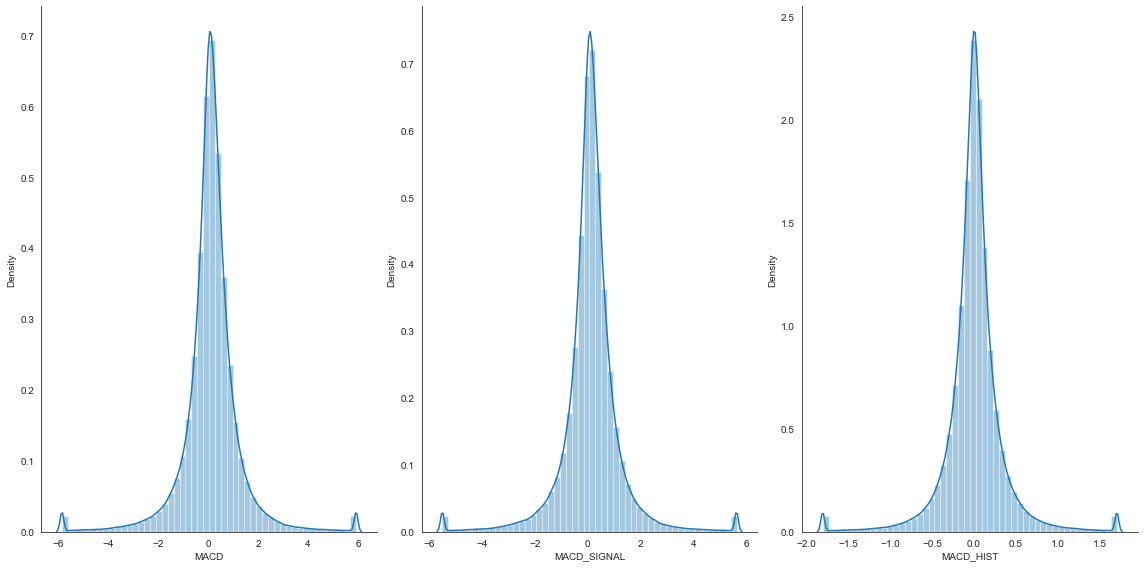

In [246]:
q = .005
with sns.axes_style('white'):
    fig, axes = plt.subplots(ncols=3, figsize=(16, 8))
    df_ = data[macd_indicators]
    df_ = df_.clip(df_.quantile(q), df_.quantile(1-q), axis=1)
    for i, indicator in enumerate(macd_indicators):
        sns.distplot(df_[indicator], ax=axes[i])
    sns.despine()
    fig.tight_layout();

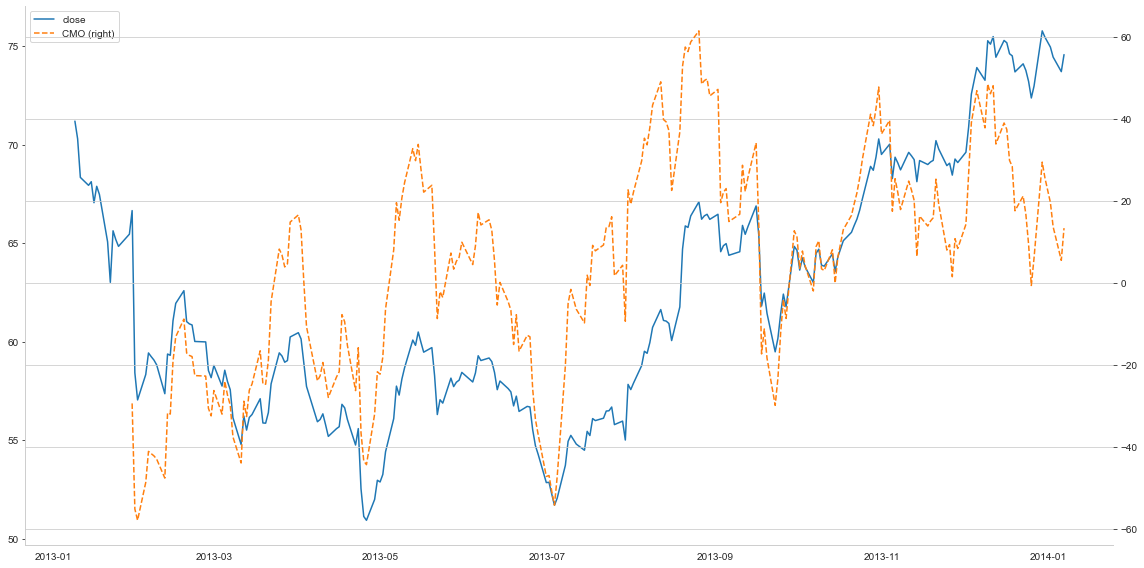

In [247]:
# 3-8. Chande Momentum Oscillator (CMO, -100 ~ 100)
# CMO > 50 : overbought
# CMO < -50 : oversold
df = price_sample.loc['2013', ['close']]
df['CMO'] = talib.CMO(df.close, timeperiod=14)
ax = df.plot(figsize=(16, 8), rot=0, secondary_y=['CMO'], style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

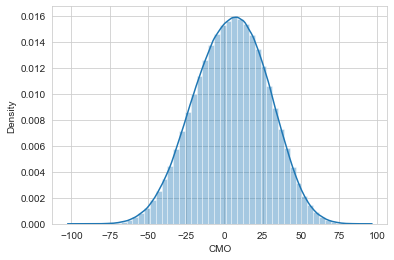

In [248]:
data['CMO'] = (by_ticker.apply(lambda x: talib.CMO(x.close, timeperiod=14)))
sns.distplot(data.CMO);

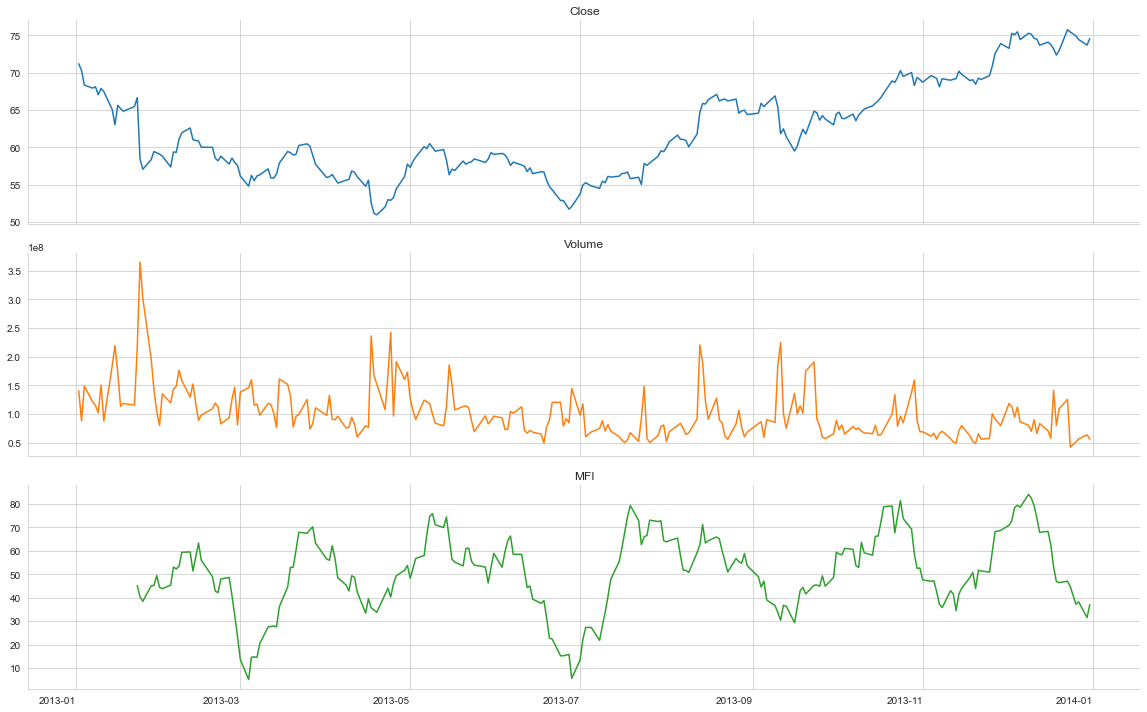

In [249]:
# 3-9. Money Flow Index - RSI + volume info, -100 ~ 100, beware of the wrong signal
# MFI >= 80 : overbought
# MFI <= 20 : oversold
df = price_sample.loc['2013', ['high', 'low', 'close', 'volume']]
df['MFI'] = talib.MFI(df.high, df.low, df.close, df.volume, timeperiod=14)
axes = df[['close', 'volume', 'MFI']].plot(figsize=(16, 10), rot=0, subplots=True,
                                           title=['Close', 'Volume', 'MFI'], legend=False)
axes[-1].set_xlabel('')
sns.despine()
plt.tight_layout()

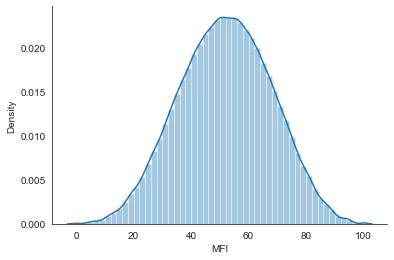

In [250]:
data['MFI'] = (by_ticker.apply(lambda x: talib.MFI(x.high, x.low, x.close, x.volume, timeperiod=14)))
with sns.axes_style('white'):
    sns.distplot(data.MFI)
    sns.despine()

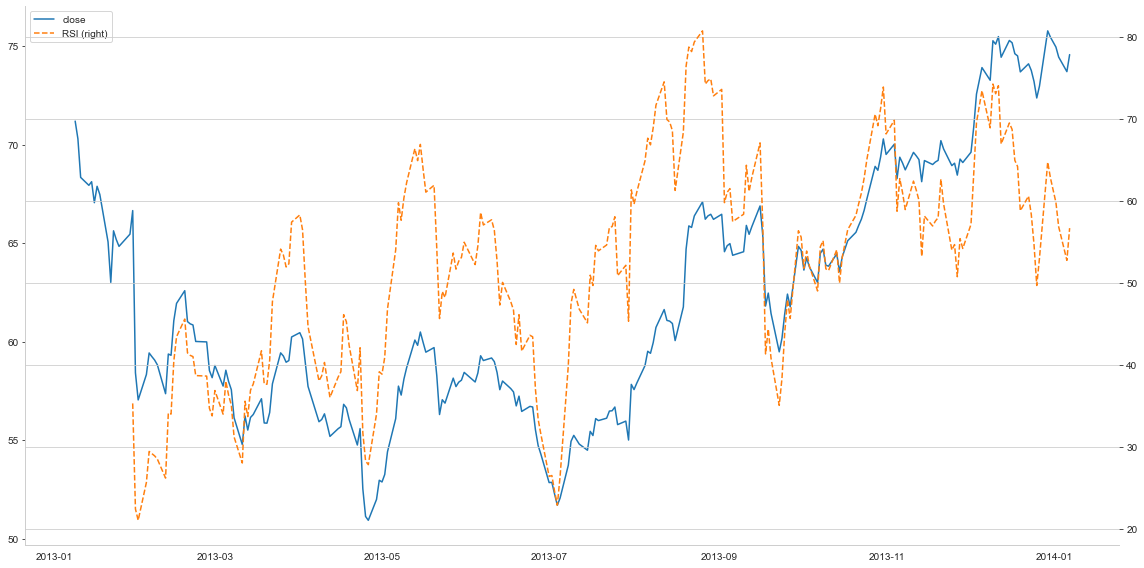

In [251]:
# 3-10. Relative Strength Index
df = price_sample.loc['2013', ['close']]
df['RSI'] = talib.RSI(df.close, timeperiod=14)
ax = df.plot(figsize=(16, 8), rot=0, secondary_y=['RSI'], style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

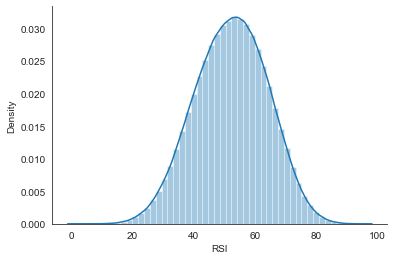

In [252]:
data['RSI'] = (by_ticker.apply(lambda x: talib.RSI(x.close, timeperiod=14)))
with sns.axes_style('white'):
    sns.distplot(data.RSI)
    sns.despine()

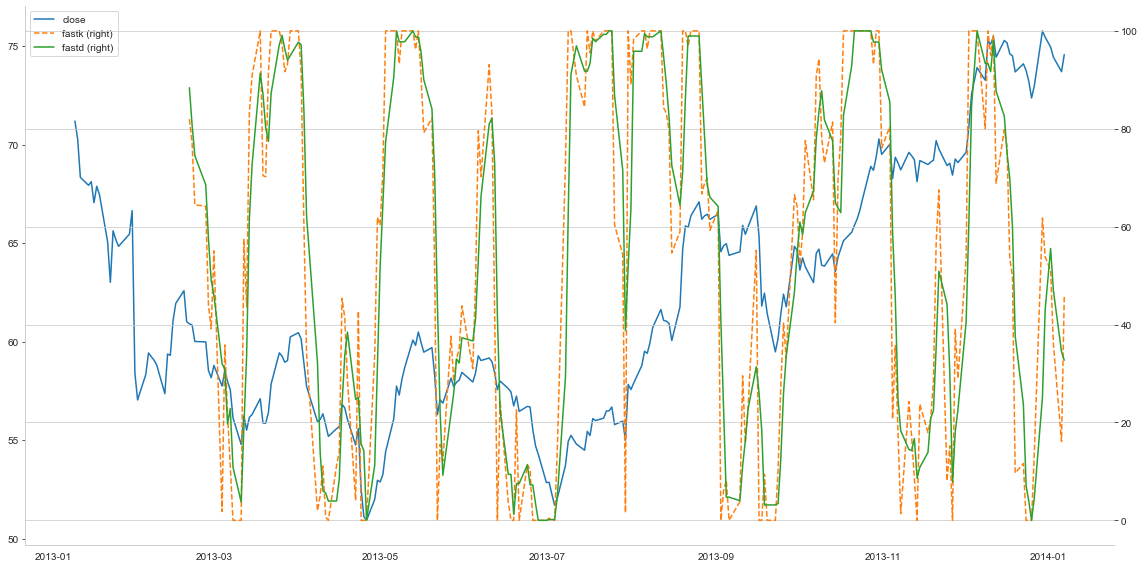

In [253]:
# 3-11. Stochastic RSI (STOCHRSI) : compares the distance of the current RSI to the lowest RSI over a given time period T to the maximum range of values the RSI has assumed for this period  to identify crossovers, as well as overbought and oversold conditions(0 ~ 100)
# STOCHRSI >= 80 : overbought
# STOCHRSI <= 20 : oversold
# STOCHRSI exhibits the faster movement than RSI between overbought and oversold area
df = price_sample.loc['2013', ['close']]
fastk, fastd = talib.STOCHRSI(df.close, timeperiod=14, fastk_period=14, fastd_period=3, fastd_matype=0)
df['fastk'] = fastk # unsmoothed RSI
df['fastd'] = fastd # smoothed StochRSI
ax = df.plot(figsize=(16, 8), rot=0, secondary_y=['fastk', 'fastd'], style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [254]:
data['STOCHRSI'] = (by_ticker.apply(lambda x: talib.STOCHRSI(x.close, timeperiod=14, fastk_period=14,
                                                             fastd_period=3, fastd_matype=0)[0]))
data.tail(5)

open       high        low      close     volume  \
ticker date                                                                
ZION   2016-12-22  43.341979  43.669875  42.934592  43.461214  1555955.0   
       2016-12-23  43.500959  43.659939  43.309189  43.580449  1243449.0   
       2016-12-27  43.818919  43.868601  43.391660  43.650003  1096332.0   
       2016-12-28  43.749366  43.749366  42.904783  43.004146  1055176.0   
       2016-12-29  42.994210  43.361851  42.358289  42.517269  1551615.0   

                      marketcap  sector    ret_01    ret_02    ret_03  ...  \
ticker date                                                            ...   
ZION   2016-12-22  1.032000e+10     0.0  0.002291 -0.003872  0.024356  ...   
       2016-12-23  1.032000e+10     0.0  0.002743  0.005041 -0.001139  ...   
       2016-12-27  1.032000e+10     0.0  0.001596  0.004344  0.006645  ...   
       2016-12-28  1.032000e+10     0.0 -0.014796 -0.013224 -0.010517  ...   
       2016-12-29  1.032000e+10     0.0 -0.011322 -0.025950 -0.024396  ...   

                     AARONOSC       BOP         CCI      MACD  MACD_SIGNAL  \
ticker date                                                                  
ZION   2016-12-22   85.714286  0.162162  104.836046  1.821960     1.923030   
       2016-12-23   71.428571  0.226629  111.975984  1.786418     1.895708   
       2016-12-27  100.000000 -0.354167  112.400709  1.743762     1.865319   
       2016-12-28   57.142857 -0.882353   52.625942  1.638949     1.820045   
       2016-12-29   57.142857 -0.475248   -9.411910  1.499314     1.755899   

                   MACD_HIST        CMO        MFI        RSI   STOCHRSI  
ticker date                                                               
ZION   2016-12-22  -0.101070  42.755876  62.727841  71.377938  29.606069  
       2016-12-23  -0.109290  43.688947  61.182241  71.844474  32.291696  
       2016-12-27  -0.121556  44.259709  59.062367  72.129855  33.934500  
       2016-12-28  -0.181096  30.983398  54.498530  65.491699   0.000000  
       2016-12-29  -0.256585  21.877489  46.193086  60.938744   0.000000  

[5 rows x 37 columns]

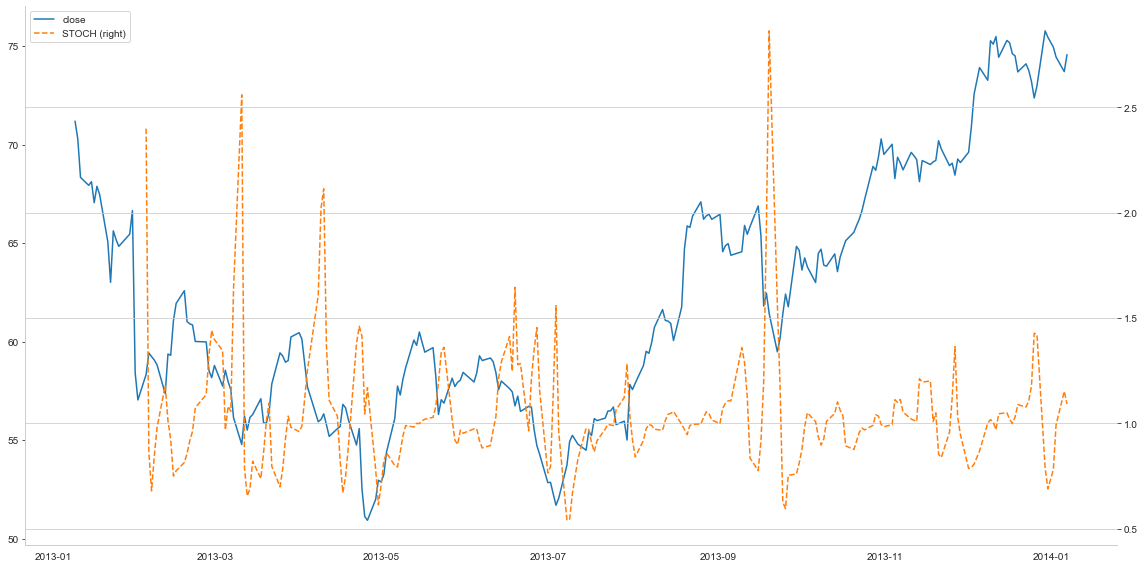

In [255]:
# 3-12. Stochastic oscillator (STOCH) : momentum indicator that compares a particular closing price of a security to a range of its prices over a certain period of time(based on the idea that closing prices should confirm the trend), developed to increase the sensitivity of RSI.
# STOCH >= 80 : overbought
# STOCH <= 20 : oversold
df = price_sample.loc['2013', ['high', 'low', 'close']]
slowk, slowd = talib.STOCH(df.high, df.low, df.close, fastk_period=14, slowk_period=3, slowk_matype=0,
                           slowd_period=3, slowd_matype=0)
df['STOCH'] = slowd / slowk
ax = df[['close', 'STOCH']].plot(figsize=(16, 8), rot=0, secondary_y='STOCH', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

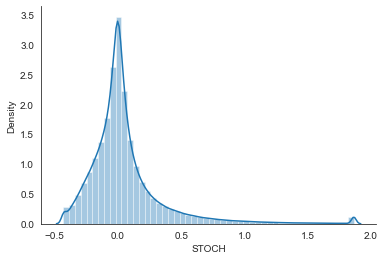

In [256]:
def compute_stoch(x, fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0):
    slowk, slowd = talib.STOCH(x.high, x.low, x.close, fastk_period=fastk_period, slowk_period=slowk_period,
                           slowk_matype=slowk_matype, slowd_period=slowd_period, slowd_matype=slowd_matype)
    return slowd/slowk-1
data['STOCH'] = by_ticker.apply(compute_stoch)
data.loc[data.STOCH.abs() > 1e5, 'STOCH'] = np.nan
q = 0.005
with sns.axes_style('white'):
    sns.distplot(data.STOCH.clip(lower=data.STOCH.quantile(q), upper=data.STOCH.quantile(1-q)));

    sns.despine();

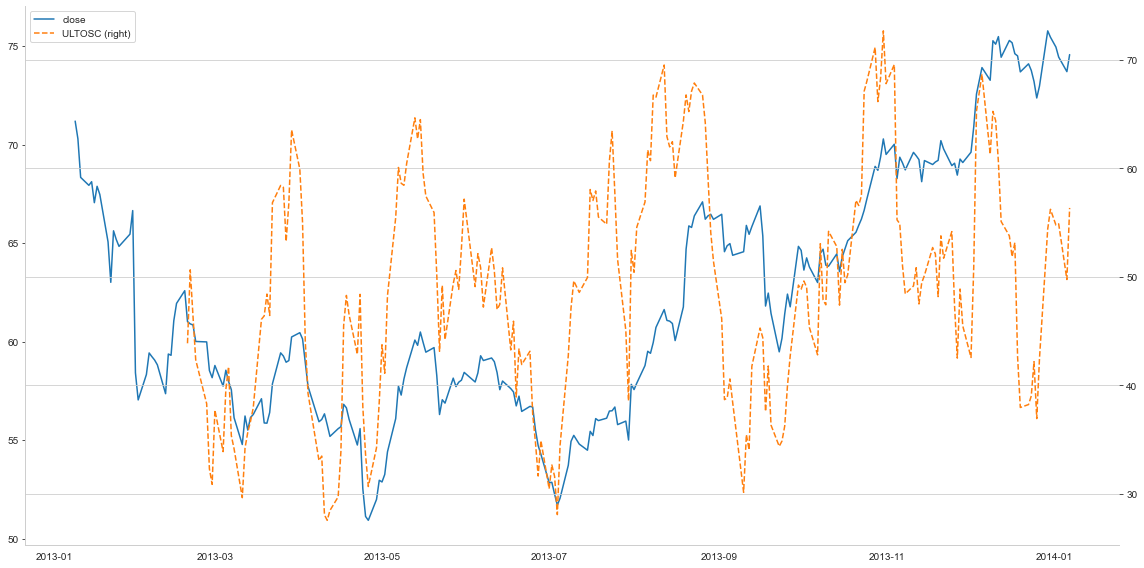

In [257]:
# 3-13. Ultimate Oscillator (ULTOSC) : measures the average difference between the current close and the previous lowest price over three timeframes to avoid overreacting to short-term price changes and incorporate short-, medium-, and long-term market trends(0 ~ 100)
# ULTOSC >= 70 : overbought
# ULTOSC <= 30 : oversold
df = price_sample.loc['2013', ['high', 'low', 'close']]
df['ULTOSC'] = talib.ULTOSC(df.high, df.low, df.close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
ax = df[['close', 'ULTOSC']].plot(figsize=(16, 8), rot=0, secondary_y='ULTOSC', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

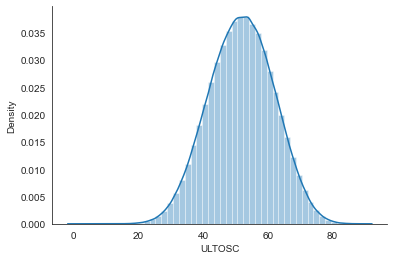

In [258]:
def compute_ultosc(x, timeperiod1=7, timeperiod2=14, timeperiod3=28):
    return talib.ULTOSC(x.high, x.low, x.close, timeperiod1=timeperiod1, timeperiod2=timeperiod2,
                        timeperiod3=timeperiod3)
data['ULTOSC'] = by_ticker.apply(compute_ultosc)
with sns.axes_style('white'):
    sns.distplot(data.ULTOSC)
    sns.despine();

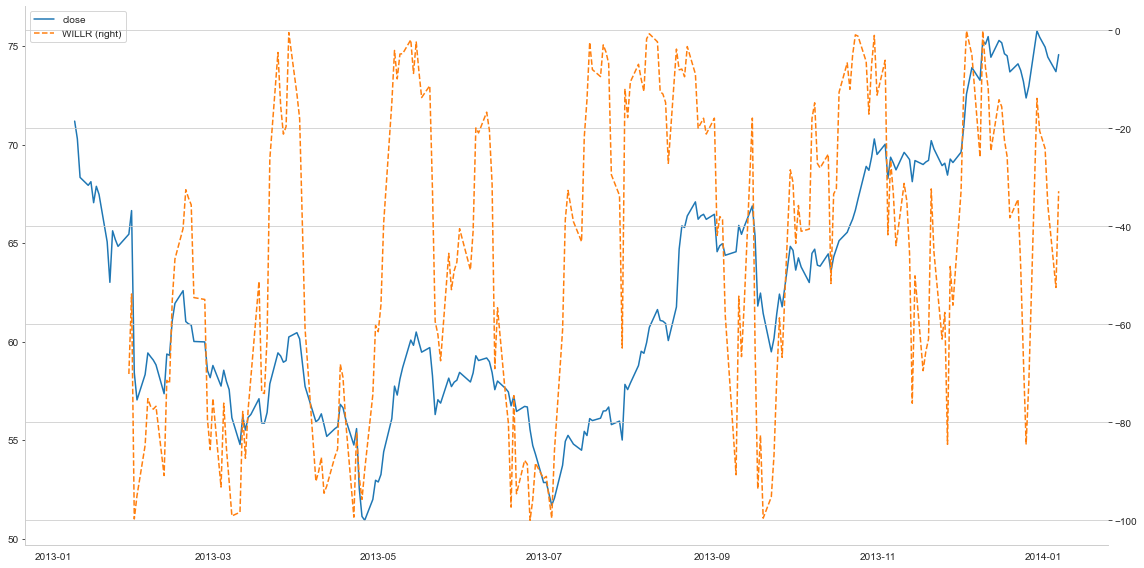

In [259]:
# 3-14. Williams' %R (WILLR) : measures overbought and oversold levels to identify entry and exit points(0 ~ -100), beware of the wrong signal as high sensitivity indicator
# WILLR 0 ~ -20 : overbought ==> sell signal
# WILLR -80 ~ -100 : oversold ==> buying signal
df = price_sample.loc['2013', ['high', 'low', 'close']]
df['WILLR'] = talib.WILLR(df.high, df.low, df.close, timeperiod=14)
ax = df[['close', 'WILLR']].plot(figsize=(16, 8), rot=0, secondary_y='WILLR', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

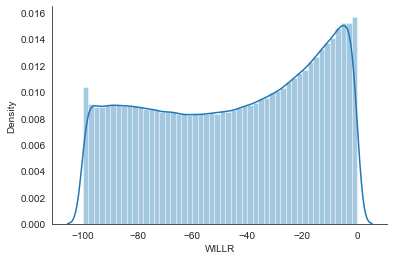

In [260]:
data['WILLR'] = by_ticker.apply(lambda x: talib.WILLR(x.high, x.low, x.close, timeperiod=14))
with sns.axes_style('white'):
    sns.distplot(data.WILLR)
    sns.despine();

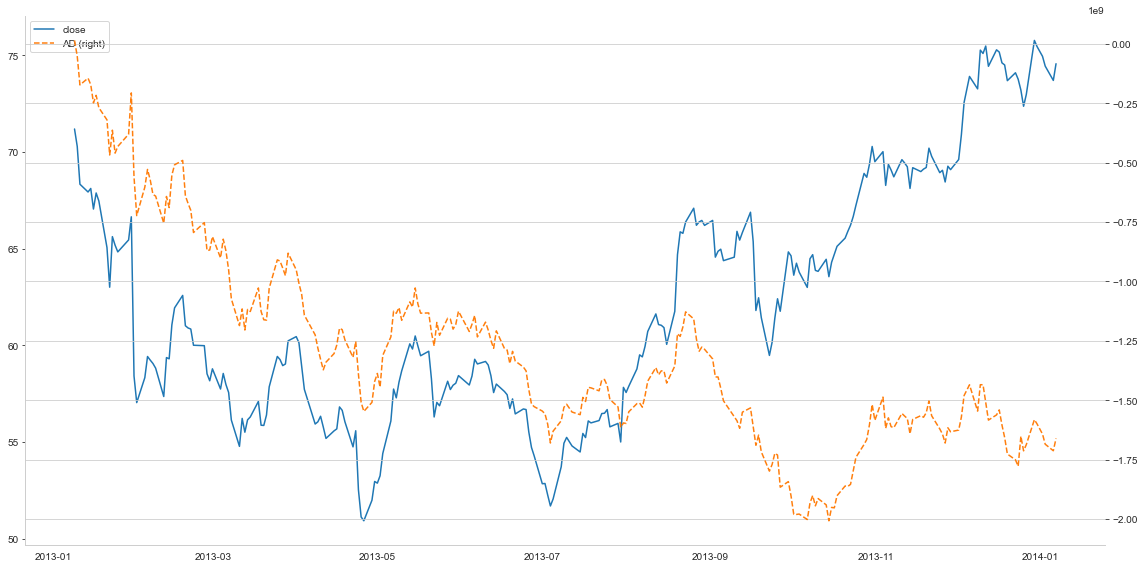

In [261]:
# 4. Volume Indicators: AD(Chaikin A/D Line), ADOSC(Chaikin A/D Oscillator), OBV(On Balance Volume)

# 4-1. Chaikin A/D Line(volume-based indicator) : to measure the cumulative flow of money into and out of an asset(assumption: the degree of buying or selling pressure can be determined by the location of the close, relative to the high and low for the period)
# Chaikin A/D Line upward trend : buying signal(following A/D line instead of stock price when divergence)
# Chaikin A/D Line downward trend : sell signal(following A/D line instead of stock price when divergence)
df = price_sample.loc['2013', ['high', 'low', 'close', 'volume']]
df['AD'] = talib.AD(df.high, df.low, df.close, df.volume)
ax = df[['close', 'AD']].plot(figsize=(16, 8), rot=0, secondary_y='AD', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [262]:
data['AD'] = by_ticker.apply(lambda x: talib.AD(x.high, x.low, x.close, x.volume)/x.volume.mean())
data.AD.replace((np.inf, -np.inf), np.nan).dropna().describe()

count    1.255093e+06
mean     3.820196e+01
std      4.457350e+01
min     -1.562873e+02
25%      5.206637e+00
50%      3.226342e+01
75%      6.711474e+01
max      2.413463e+02
Name: AD, dtype: float64

In [263]:
data.AD.sample(10)

ticker  date      
OKE     2007-11-13     -2.283656
CE      2011-06-27     47.128665
ROK     2014-02-11     73.045154
OXY     2014-09-30     74.164247
DTV     2008-03-25     -1.498998
HSIC    2009-06-17     13.648759
QCOM    2014-07-24     65.817019
CNP     2016-03-23    104.236268
PCG     2016-05-23     92.256530
HLF     2015-02-27    -29.367668
Name: AD, dtype: float64

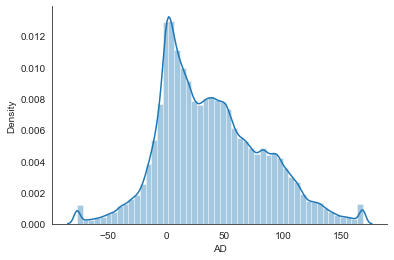

In [264]:
q = 0.005
AD = data.AD.replace((np.inf, -np.inf), np.nan).dropna()
with sns.axes_style('white'):
    sns.distplot(AD.clip(lower=AD.quantile(q), upper=AD.quantile(1-q)));

    sns.despine();

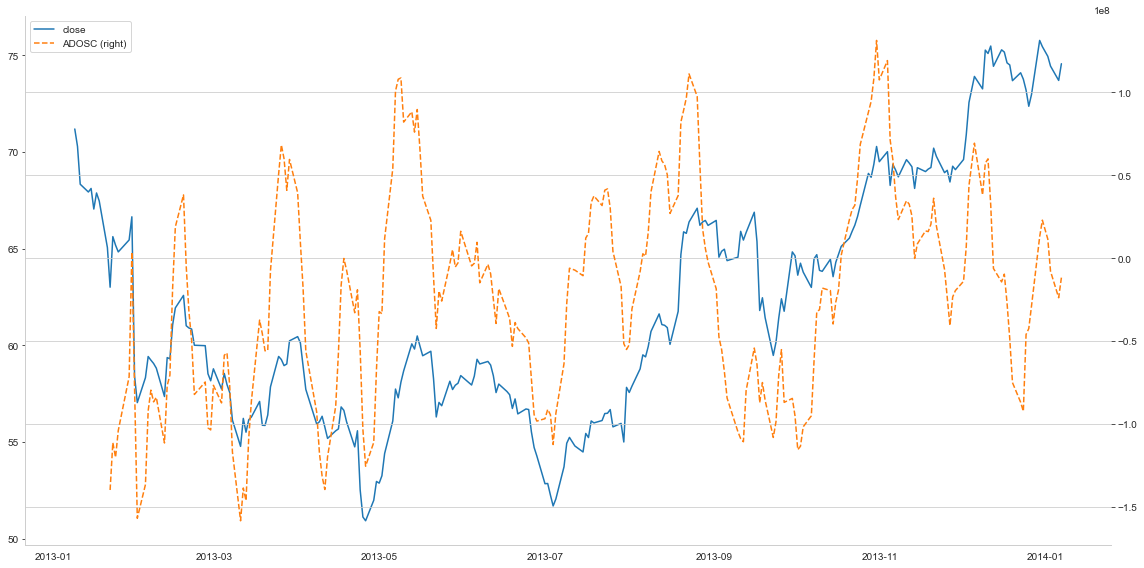

In [265]:
# 4-2. Chaikin A/D Oscillator (ADOSC) : MACD indicator that's applied to the Chaikin AD line to predict changes in the line, computed as the difference between the 3-day EMA and the 10-day EMA of the AD line
df = price_sample.loc['2013', ['high', 'low', 'close', 'volume']]
df['ADOSC'] = talib.ADOSC(df.high, df.low, df.close, df.volume, fastperiod=3, slowperiod=10)
ax = df[['close', 'ADOSC']].plot(figsize=(16, 8), rot=0, secondary_y='ADOSC', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

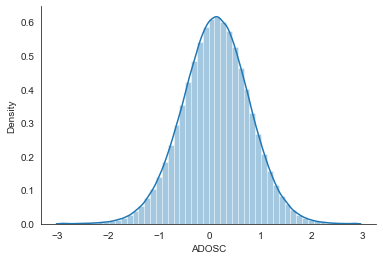

In [266]:
data['ADOSC'] = by_ticker.apply(lambda x: talib.ADOSC(x.high, x.low, x.close, x.volume, fastperiod=3,
                                                      slowperiod=10)/x.rolling(14).volume.mean())
q = 0.0001
with sns.axes_style('white'):
    sns.distplot(data.ADOSC.clip(lower=data.ADOSC.quantile(q), upper=data.ADOSC.quantile(1-q)))
    sns.despine();

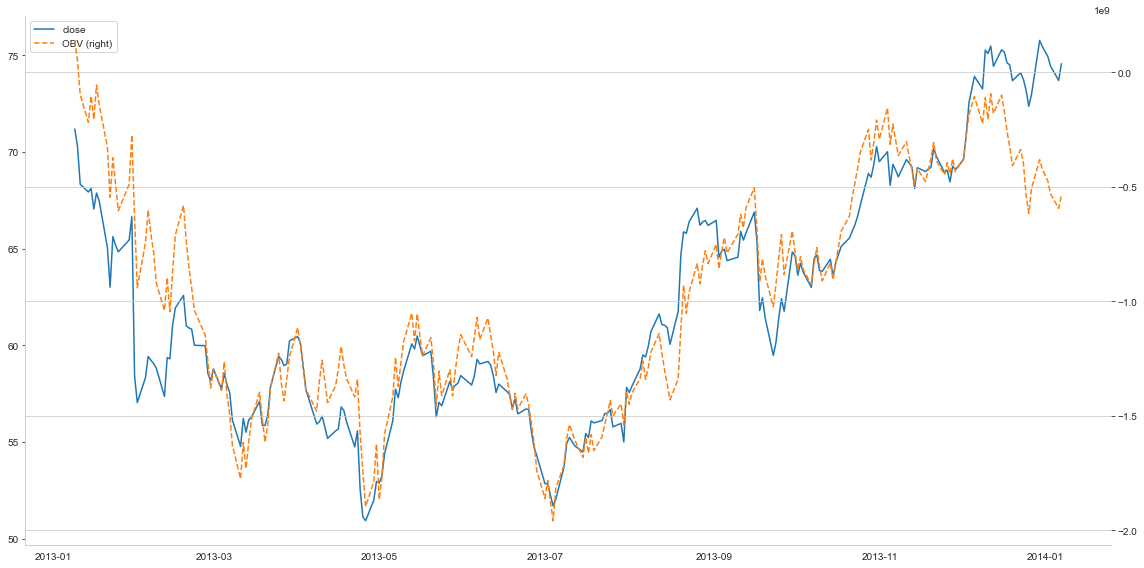

In [267]:
# 4-3. On Balance Volume (OBV) : cumulative momentum indicator that relates volume to price change(assumption: OBV changes precede price changes because smart money can be seen flowing into the security by a rising OBV)
df = price_sample.loc['2013', ['close', 'volume']]
df['OBV'] = talib.OBV(df.close, df.volume)
ax = df[['close', 'OBV']].plot(figsize=(16, 8), rot=0, secondary_y='OBV', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

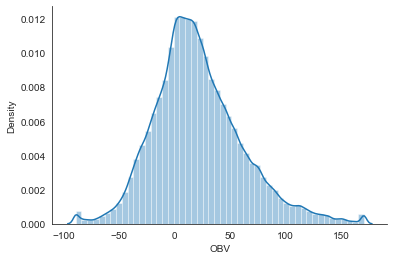

In [268]:
data['OBV'] = by_ticker.apply(lambda x: talib.OBV(x.close, x.volume)/x.expanding().volume.mean())
q = 0.0025
with sns.axes_style('white'):
    sns.distplot(data.OBV.clip(lower=data.OBV.quantile(q), upper=data.OBV.quantile(1-q)))
    sns.despine()

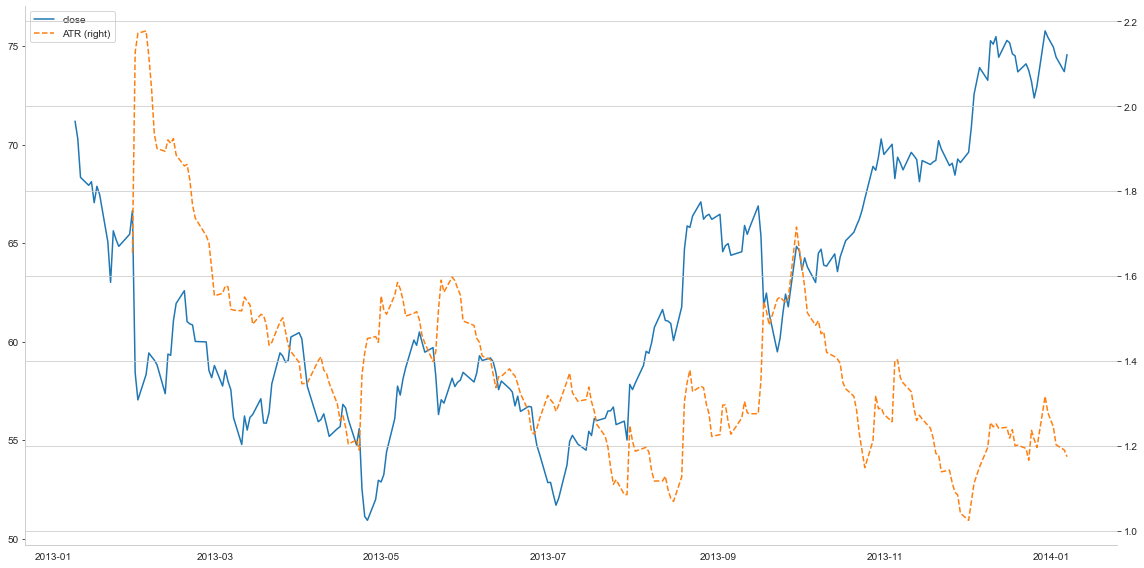

In [269]:
# 5. Volatility Indicators: TRANGE(True Range), ATR(Average True Range), NATR(Normalized Average True Range)

# 5-1. ATR : to anticipate changes in trend such that the higher its value, the higher the probability of a trend change; the lower the indicator's value, the weaker the current trend
df = price_sample.loc['2013', ['high', 'low', 'close']]
df['ATR'] = talib.ATR(df.high, df.low, df.close, timeperiod=14)
ax = df[['close', 'ATR']].plot(figsize=(16, 8), rot=0, secondary_y='ATR', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

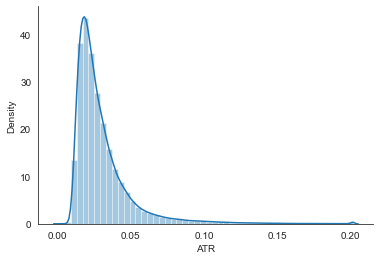

In [270]:
# Compute normalized version of ATR using rolling mean of price
data['ATR'] = by_ticker.apply(lambda x: talib.ATR(x.high, x.low, x.close,
                                                  timeperiod=14)/x.rolling(14).close.mean())
q = 0.001
with sns.axes_style('white'):
    sns.distplot(data.ATR.clip(upper=data.ATR.quantile(1-q)))
    sns.despine()

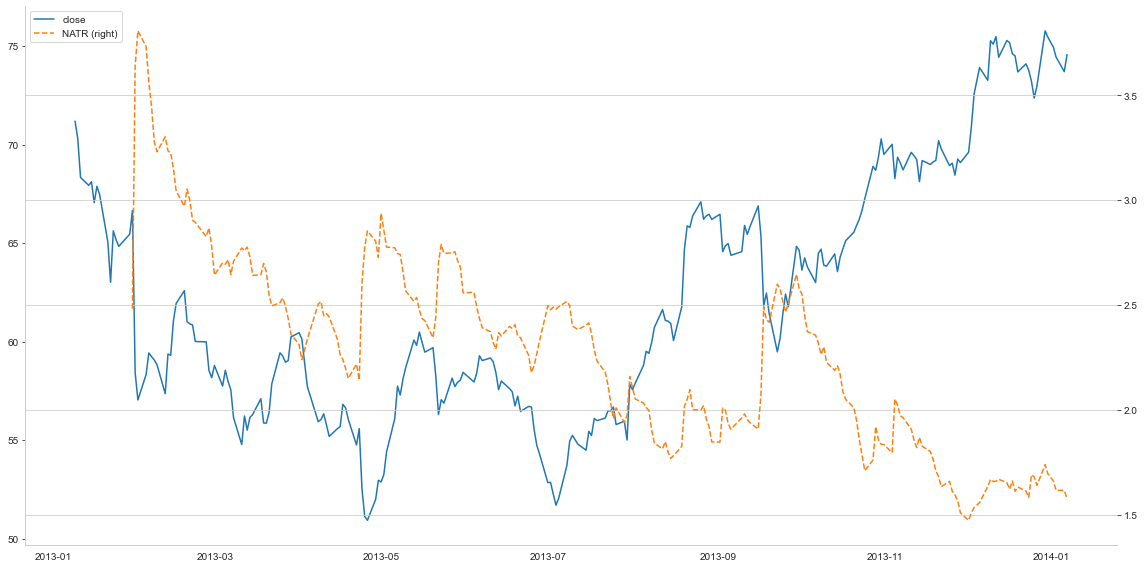

In [271]:
# 5-2. Normalized Average True Range (NATR) : can utilize to compare across assets as Normalization makes the ATR more relevant for long-term analysis where the price changes substantially and for cross-market or cross-security comparisons
df = price_sample.loc['2013', ['high', 'low', 'close']]
df['NATR'] = talib.NATR(df.high, df.low, df.close, timeperiod=14)
ax = df[['close', 'NATR']].plot(figsize=(16, 8), rot=0, secondary_y='NATR', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

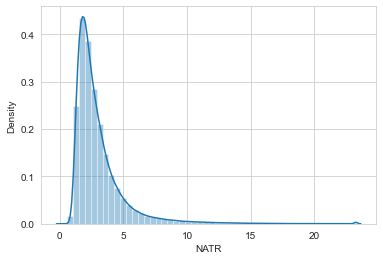

In [272]:
data['NATR'] = by_ticker.apply(lambda x: talib.NATR(x.high, x.low, x.close, timeperiod=14))
q = 0.001
sns.distplot(data.NATR.clip(upper=data.NATR.quantile(1-q)));

In [273]:
# Rolling Factor Betas(Fundamental risk factors)
factor_data = (web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench',
                              start=2005)[0].rename(columns={'Mkt-RF': 'MARKET'}))
factor_data.index.names = ['date']
factors = factor_data.columns[:-1]
print(f'factors: {factors}')

t = 1
ret = f'ret_{t:02}'
windows = [21, 63, 252]
for window in windows:
    print(window)
    betas = []
    for ticker, df in data.groupby('ticker', group_keys=False):
        model_data = df[[ret]].merge(factor_data, on='date').dropna()
        model_data[ret] -= model_data.RF

        rolling_ols = RollingOLS(endog=model_data[ret],
                                 exog=sm.add_constant(model_data[factors]), window=window)
        factor_model = rolling_ols.fit(params_only=True).params.rename(columns={'const':'ALPHA'})
        result = factor_model.assign(ticker=ticker).set_index('ticker', append=True).swaplevel()
        betas.append(result)
    betas = pd.concat(betas).rename(columns=lambda x: f'{x}_{window:02}')
    data = data.join(betas)

factors: Index(['MARKET', 'SMB', 'HML', 'RMW', 'CMA'], dtype='object')
21
63
252


In [274]:
# Size proxy
data['size_factor'] = by_ticker.close.apply(lambda x: x.fillna(method='bfill').div(x.iloc[0]))
data['size_proxy'] = data.marketcap.mul(data.size_factor).div(1e6)
# Persist results
data = (data.drop(['open', 'high', 'low', 'close', 'volume', 'marketcap'], axis=1)
        .replace((np.inf, -np.inf), np.nan))
data.dropna(how='all').info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1255093 entries, ('A', Timestamp('2007-01-04 00:00:00')) to ('ZION', Timestamp('2016-12-29 00:00:00'))
Data columns (total 59 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   sector       1255093 non-null  float64
 1   ret_01       1254593 non-null  float64
 2   ret_02       1254093 non-null  float64
 3   ret_03       1253593 non-null  float64
 4   ret_04       1253093 non-null  float64
 5   ret_05       1252593 non-null  float64
 6   ret_10       1250093 non-null  float64
 7   ret_21       1244593 non-null  float64
 8   ret_42       1234093 non-null  float64
 9   ret_63       1223593 non-null  float64
 10  ret_126      1192093 non-null  float64
 11  ret_252      1129093 non-null  float64
 12  ret_fwd      1255093 non-null  float64
 13  BB_UP        1245593 non-null  float64
 14  BB_LOW       1245593 non-null  float64
 15  BB_SQUEEZE   1245593 non-null  float64
 16  HT           1223

In [278]:
data.sample(10).sort_values(by='date')

sector    ret_01    ret_02    ret_03    ret_04    ret_05  \
ticker date                                                                   
PTEN   2007-11-20     8.0  0.003064 -0.019471 -0.028684 -0.043817 -0.036310   
AMGN   2009-01-12     6.0 -0.012461 -0.037125 -0.019588 -0.021940 -0.043420   
ZION   2011-02-10     0.0 -0.026503 -0.031102 -0.026503  0.000407  0.016522   
GOOGL  2011-05-13     2.0 -0.010279 -0.011019 -0.024159 -0.015121 -0.010742   
MS     2013-01-02     0.0  0.026151  0.053706  0.045285  0.039195  0.035356   
GT     2013-06-27     7.0  0.004695  0.018355  0.051597  0.002677  0.009434   
DKS    2014-04-03     1.0  0.000362  0.001993  0.012452 -0.005576  0.001086   
SYY    2014-12-10    11.0 -0.014011 -0.014996 -0.013023 -0.010793 -0.013764   
NOC    2015-06-30     4.0 -0.000315 -0.019410 -0.021588 -0.028062 -0.034921   
TGNA   2016-10-06     1.0 -0.015441 -0.009141 -0.019448 -0.008234  0.006032   

                     ret_10    ret_21    ret_42    ret_63  ...    RMW_63  \
ticker date                                                ...             
PTEN   2007-11-20 -0.060736 -0.067869 -0.135940 -0.062815  ...  0.003731   
AMGN   2009-01-12 -0.005230 -0.017054 -0.029262  0.174557  ...  0.008629   
ZION   2011-02-10  0.035774  0.012341  0.053510  0.118636  ... -0.007707   
GOOGL  2011-05-13 -0.026741 -0.081089 -0.070247 -0.152042  ... -0.011453   
MS     2013-01-02  0.058824  0.163011  0.128884  0.172043  ...  0.005536   
GT     2013-06-27 -0.032924 -0.020275  0.191726  0.188417  ...  0.013522   
DKS    2014-04-03 -0.024007  0.036169  0.094427 -0.036874  ...  0.004007   
SYY    2014-12-10 -0.001267  0.019664  0.063985  0.037862  ...  0.004796   
NOC    2015-06-30 -0.017710 -0.008191  0.034931 -0.009563  ...  0.001289   
TGNA   2016-10-06  0.020235 -0.005961  0.027752 -0.077023  ...  0.013782   

                     CMA_63  ALPHA_252  MARKET_252   SMB_252   HML_252  \
ticker date                                                              
PTEN   2007-11-20 -0.010728        NaN         NaN       NaN       NaN   
AMGN   2009-01-12  0.012649  -0.003990    0.008102 -0.003644 -0.003201   
ZION   2011-02-10 -0.005108   0.000376    0.008341  0.004184  0.021305   
GOOGL  2011-05-13 -0.022414  -0.001555    0.013440 -0.000348 -0.004403   
MS     2013-01-02 -0.003778  -0.000579    0.013370  0.004494  0.023957   
GT     2013-06-27  0.000265  -0.000291    0.012557  0.007399  0.021132   
DKS    2014-04-03 -0.017271  -0.000014    0.010331 -0.003490 -0.002846   
SYY    2014-12-10  0.006437  -0.000026    0.007456 -0.001077 -0.005255   
NOC    2015-06-30  0.006866   0.000897    0.011092 -0.000974 -0.004658   
TGNA   2016-10-06 -0.012371  -0.001511    0.012214  0.005273  0.000288   

                    RMW_252   CMA_252  size_factor     size_proxy  
ticker date                                                        
PTEN   2007-11-20       NaN       NaN     0.915853    3617.620995  
AMGN   2009-01-12  0.004212  0.006680     0.799944   98305.108650  
ZION   2011-02-10 -0.015684 -0.012175     0.316952    3270.943632  
GOOGL  2011-05-13  0.000219 -0.012512     1.095787  849574.577867  
MS     2013-01-02 -0.019893 -0.011958     0.315057   26225.370154  
GT     2013-06-27  0.015457 -0.005255     0.660785    3687.181297  
DKS    2014-04-03  0.001999 -0.006285     2.407892    8692.491792  
SYY    2014-12-10  0.003809  0.004704     1.420191   50715.029502  
NOC    2015-06-30  0.000971  0.007341     3.310116  178282.853867  
TGNA   2016-10-06  0.001942 -0.003429     0.634205    1484.039439  

[10 rows x 59 columns]

In [275]:
with pd.HDFStore('data/data_alpha_factor.h5') as store:
    store.put('factors/common', data)